# Publishing Version of my Master's Thesis on the Semantics of (made-up) Names
<br>


### Author: Aron Joosse
### Supervisor: Giovanni Cassani
### Institution: Tilburg University
### Grade Acquired: 9

# Library Imports

In [68]:
!pip install fasttext --progress-bar off
!pip install -U spacy --progress-bar off
!python -m spacy download en_core_web_sm
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-10-10 10:57:55.567120: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 11.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
from google.colab import drive

# Preprocessing
import re
import os
import spacy
import pickle
import pandas as pd
from pandas import read_csv

# FastText
import fasttext
import fasttext.util

import random

# MEN and SimLex Benchmarks
from os import listdir
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity

# ElasticNet and ANN
import sklearn
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, KFold, LeaveOneOut, StratifiedKFold
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error, median_absolute_error
from sklearn.linear_model import ElasticNetCV

import numpy as np
from numpy import mean
from numpy import std
from numpy import absolute
from numpy.random import seed

from scipy import stats

# PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import time

from statistics import median

from tensorflow import keras
from tensorflow.random import set_seed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import MaxPooling2D, MaxPooling1D, Conv2D, Conv1D, Bidirectional
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

# Data Import

In [70]:
## Getting the list of madeup names:
drive.mount("/content/drive", force_remount=True) 
ratings_csv = pd.read_csv("drive/MyDrive/Thesis/Data/giovanni_email_data/avgRatings_annotated.csv",
                          usecols = ["name", "name_type"])                      ## Importing the names and name types

ratings_csv.head(10)

madeup_names = []

for i in ratings_csv.index:                                                     ## Only choosing madeup names so I can filter them out of the FT vocab
  if ratings_csv["name_type"][i] == "madeup":
    madeup_names.append(str(ratings_csv["name"][i]))

madeup_names_lower = list(map(lambda x: x.lower(), madeup_names))               ## Lowercasting the names since my entire vocab will be lowercast

print(madeup_names[:5])
print(len(madeup_names))
print(madeup_names_lower[:5])
print(len(madeup_names_lower))

Mounted at /content/drive
['Alastor', 'Alecto', 'Amabala', 'Araminta', 'Arcturus']
60
['alastor', 'alecto', 'amabala', 'araminta', 'arcturus']
60


In [71]:
path = "drive/My Drive/Thesis/Data/CoCA/Text/"                                  ## These are the paths to easily export/import my dicts, txts, models, and pickles
dict_path = "drive/My Drive/Thesis/Data/CoCA/dict_pickles/"
unclean_path = path + "texts_combined/all_texts_combined.txt"
model_path = "drive/My Drive/Thesis/Data/CoCA/models/"
pickle_path = "drive/MyDrive/Thesis/Data/fastText and others/"
norms_path = "drive/My Drive/Thesis/Data/Norms/"
csv_path = "drive/My Drive/Thesis/Data/CSV/"
delta_path = "drive/My Drive/Thesis/Data/Deltacode/"

## COCA

In [ ]:
unclean_corpus = open(unclean_path).read()                                      ## Importing the entire coca

In [ ]:
print(len(unclean_corpus))                                                      ## Showing the length and first 100 characters of the coca
print(unclean_corpus[:100])

2977527143
@@4170367 Headnote # A puzzle has long pervaded the criminal law : why are two offenders who commit 


## Names

In [72]:
### Read CSV File and Delete Unimportant Columns (i.e., everything that isn't the name, name type, rating, or the author's choice)

### This is input for the FT model, which itself is the input for the ElasticNet and ANN regressions

names_ratings = read_csv("drive/MyDrive/Thesis/Data/giovanni_email_data/avgRatings_annotated.csv")

#print(names_ratings.head())

print(names_ratings['rating.mean_age'].notna().sum())                           ## Choosing only those rows where all columns are not NA
print(names_ratings['rating.mean_gender'].notna().sum())
print(names_ratings['rating.mean_valence'].notna().sum())

df_age = names_ratings.loc[names_ratings['rating.mean_age'].notna(), ['name', 'rating.mean_age', 'age', 'name_type']]   ## Choosing the relevant columns
print(df_age.head(), len(df_age))

df_gender = names_ratings.loc[names_ratings['rating.mean_gender'].notna(), ['name', 'rating.mean_gender', 'gender', 'name_type']]
print(df_gender.head(), len(df_gender))

df_polarity = names_ratings.loc[names_ratings['rating.mean_valence'].notna(), ['name', 'rating.mean_valence', 'polarity', 'name_type']]
print(df_polarity.head(), len(df_polarity))

119
179
63
       name  rating.mean_age    age name_type
0  Adelaide        -0.617647    old      real
2  Alasdair        18.709677  young      real
3   Alastor        13.812500    old    madeup
4    Alecto         3.593750    old    madeup
5     Alice       -13.969697  young      real 119
       name  rating.mean_gender  gender name_type
0  Adelaide           45.727273  female      real
1   Adelina           47.771429  female      real
2  Alasdair          -35.657143    male      real
3   Alastor          -38.833333    male    madeup
4    Alecto          -35.722222  female    madeup 179
        name  rating.mean_valence polarity name_type
1    Adelina            31.621622      bad      real
7    Amabala             5.935484     good    madeup
8      Apple            32.444444     good   talking
11  Arcturus           -11.166667     good    madeup
13   Arobynn             7.645161      bad    madeup 63


# Preprocessing


## Cleaning Corpus

In [ ]:
## Loading the English spacy pipeline and removing stopwords (since we are interested in gender bias, it's best to leave these words in)

nlp = spacy.load("en_core_web_sm")
nlp.max_length = 10000000000

nlp.Defaults.stop_words.remove('him')
nlp.Defaults.stop_words.remove('her')
nlp.Defaults.stop_words.remove('hers')
nlp.Defaults.stop_words.remove('his')
nlp.Defaults.stop_words.remove('he')
nlp.Defaults.stop_words.remove('she')
nlp.Defaults.stop_words.remove('himself')
nlp.Defaults.stop_words.remove('herself')

In [ ]:
def clean_corpus_sentenced(data, corpus_dict, index):
  ## Input: 
  # - Data = A (very) large string of corpus text
  # - Corpus_dict = a dictionary to store individual sentences in
  # - Index = the last index from the previous batch

  ## Process: 
  # Remove all unwanted tokens, and store individual sentences in the dictionary

  ## Output: 
  # - The dictionary of preprocessed sentences
  # - The last sentence index, for the next batch to continue with (so that the order of the sentences is kept)

  # Tokenization
  with nlp.select_pipes(disable=["lemmatizer", "tok2vec", "tagger", "parser"]):
    nlp.enable_pipe("senter")                                                   ## Helps with better segmenting into sentences
    doc = nlp(data)

  sentence = ""                                                                 ## Initialize an empty sentence

  for token in doc:
    if token.is_sent_start is True:                                             ## If token is the star of the sentence, add the previous sentence to the dictionary
      if sentence == "":                                                        ## and create a new, clean sentence
        continue
      else:
        corpus_dict[index] = sentence
        sentence = ""
        index += 1
    
    if token.is_upper is True:                                                  ## Remove all full-caps words
      continue
    elif token.is_stop is True:                                                 ## Remove all stopwords
      continue
    elif str(token).lower() in madeup_names_lower:                              ## Remove all words that are in my list of made-up names
      continue
    elif token.is_alpha:                                                        ## If the token has passed all previous tests, and it consists only of alphabetic
      sentence += str(token).lower() + " "                                      ## characters, lowercast it and add an extra space to the end; continue to the next
                                                                                ## token
  return corpus_dict, index

In [ ]:
def corpus_dict_maker(data, start, end, index):
  ## Input: 
  # - Data = The entire uncleaned corpus
  # - Start = The character index to indicate the start of the current batch to preprocess
  # - End = The character index to indicate the end of the current batch to preprocess
  # - Index = The sentence index from the previous batch, to keep track of the number and order of the sentences

  ## Process: 
  # Preprocess the corpus in batches, since there was not enough RAM to preprocess the entire corpus at once
  # So, for every batch, all the characters between the start index and the end index are fed into the clean_corpus_sentenced() function
  # and then this dictionary of sentences is saved as a pickle to Google drive

  ## Output: 
  # Nothing; except that the sentence index is printed, which is used as input for the next batch (this was printed, so that it couldn't be lost if the 
  # runtime would disconnect (which it sadly did very often))

  drive.mount("/content/drive", force_remount=True)                             ## Connect to google drive
  
  corpus_dict = {}                                                              ## Create empty dictionary

  prev_i = (start-2)*1000000                                                    ## Start with preprocessing the two million characters before the previous index
                                                                                ## since the next range only preprocesses up to but not including the 'end' index

  for i in range(start, end, 2):                                                ## In batches of 2 million characters, feed the batch to clean_corpus_sentenced()
    print(i)                                                                   
    i *= 1000000
    corpus_dict, index = clean_corpus_sentenced(data[prev_i:i],
                                                corpus_dict,
                                                index)
    prev_i = i
  
  if prev_i == 2976000000:                                                      ## Hardcoded; if we get near the end of the corpus, don't preprocess in a batch of
    corpus_dict, index = clean_corpus_sentenced(data[prev_i:],                  ## 2 million characters (we would get an out of range error), but rather just 
                                                corpus_dict,                    ## preprocess the remaining characters, however many that may be
                                                index)

  print(index)

  pickle_out = open(dict_path + "corpus_dict_until_" + str(end) + ".pickle", "wb")  ## Save the dictionary as a pickle
  pickle.dump(corpus_dict, pickle_out)
  pickle_out.close()

  drive.flush_and_unmount()                                                     ## Flush the pickle to my drive
  print('All changes made in this colab session should now be visible in Drive.')



#### All of the individual batches:

In [ ]:
## doing it in batches to 
## (1) make it possible in terms of time and the Google afk-checker captcha pop-up, and 
## (2) to not blow out the RAM and have it break down

#corpus_dict_maker(unclean_corpus, 2, 500, 0)                   
#corpus_dict_maker(unclean_corpus, 500, 640, 3217086)           
#corpus_dict_maker(unclean_corpus, 640, 760, 4232218)           
#corpus_dict_maker(unclean_corpus, 760, 800, 5439287)           
#corpus_dict_maker(unclean_corpus, 800, 900, 5888161)
#corpus_dict_maker(unclean_corpus, 900, 980, 7020129)
#corpus_dict_maker(unclean_corpus, 980, 1150, 7891661)
#corpus_dict_maker(unclean_corpus, 1150, 1200, 9903820) 
#corpus_dict_maker(unclean_corpus, 1200, 1204, 10502592)

In [ ]:
######### This block is separate because it kept crashing if I did it otherwise:

#drive.mount("/content/drive", force_remount=True) 
#corpus_dict = {}

#prev_i = (1202)*1000000
#i = 1203*1000000
#corpus_dict, index = clean_corpus_sentenced(unclean_corpus[prev_i:i],
#                                            corpus_dict,
#                                            10547544)
#prev_i = i

#print(index)

#pickle_out = open(path + "corpus_dict_until_" + str(1203) + "_post_1204" + ".pickle", "wb")
#pickle.dump(corpus_dict, pickle_out)
#pickle_out.close()

#drive.flush_and_unmount()
#print('All changes made in this colab session should now be visible in Drive.')

################################################################################

######### This block is separate because it kept crashing if I did it otherwise:

#drive.mount("/content/drive", force_remount=True) 
#corpus_dict = {}

#prev_i = (1203)*1000000
#i = 1204*1000000
#corpus_dict, index = clean_corpus_sentenced(unclean_corpus[prev_i:i],
#                                            corpus_dict,
#                                            index + 1)
#prev_i = i

#print(index)

#pickle_out = open(path + "corpus_dict_until_" + str(1204) + "_post_1204" + ".pickle", "wb")
#pickle.dump(corpus_dict, pickle_out)
#pickle_out.close()

#drive.flush_and_unmount()
#print('All changes made in this colab session should now be visible in Drive.')

################################################################################

######### This block is separate because it kept crashing if I did it otherwise:

#drive.mount("/content/drive", force_remount=True) 
#corpus_dict = {}

#prev_i = (1204)*1000000
#i = 1205*1000000
#corpus_dict, index = clean_corpus_sentenced(unclean_corpus[prev_i:i],
#                                            corpus_dict,
#                                            10580543)
#prev_i = i

#print(index)

#pickle_out = open(path + "corpus_dict_until_" + str(1205) + "_post_1204" + ".pickle", "wb")
#pickle.dump(corpus_dict, pickle_out)
#pickle_out.close()

#drive.flush_and_unmount()
#print('All changes made in this colab session should now be visible in Drive.')

################################################################################

######### This block is separate because it kept crashing if I did it otherwise:

#drive.mount("/content/drive", force_remount=True) 
#corpus_dict = {}

#prev_i = (1205)*1000000
#i = 1206*1000000
#corpus_dict, index = clean_corpus_sentenced(unclean_corpus[prev_i:i],
#                                            corpus_dict,
#                                            index + 1)
#prev_i = i

#print(index)

#pickle_out = open(path + "corpus_dict_until_" + str(1206) + "_post_1204" + ".pickle", "wb")
#pickle.dump(corpus_dict, pickle_out)
#pickle_out.close()

#drive.flush_and_unmount()
#print('All changes made in this colab session should now be visible in Drive.')

################################################################################

In [ ]:
#corpus_dict_maker(unclean_corpus, 1208, 1300, 10611881)
#corpus_dict_maker(unclean_corpus, 1300, 1500, 11486498)
#corpus_dict_maker(unclean_corpus, 1500, 1750, 13172710)
#corpus_dict_maker(unclean_corpus, 1750, 1846, 15332847)
#corpus_dict_maker(unclean_corpus, 1846, 1848, 16123425)
#corpus_dict_maker(unclean_corpus, 1848, 1850, 16147433)
#corpus_dict_maker(unclean_corpus, 1850, 1900, 16172965)
#corpus_dict_maker(unclean_corpus, 1900, 1968, 16855832)
#corpus_dict_maker(unclean_corpus, 1968, 1970, 17790964)
#corpus_dict_maker(unclean_corpus, 1970, 2000, 17819821)
#corpus_dict_maker(unclean_corpus, 2000, 2022, 18244076)
#corpus_dict_maker(unclean_corpus, 2022, 2024, 18536113)
#corpus_dict_maker(unclean_corpus, 2024, 2026, 18558956)
#corpus_dict_maker(unclean_corpus, 2026, 2068, 18583534)
#corpus_dict_maker(unclean_corpus, 2068, 2070, 19154020)
#corpus_dict_maker(unclean_corpus, 2070, 2100, 19179335)
#corpus_dict_maker(unclean_corpus, 2100, 2166, 19598984)
#corpus_dict_maker(unclean_corpus, 2166, 2168, 20488725)
#corpus_dict_maker(unclean_corpus, 2168, 2188, 20524278)

In [ ]:
######### This block is separate because it kept crashing if I did it otherwise:

#drive.mount("/content/drive", force_remount=True) 
#corpus_dict = {}

#prev_i = (2186)*1000000
#i = 2187*1000000
#corpus_dict, index = clean_corpus_sentenced(unclean_corpus[prev_i:i],
#                                            corpus_dict,
#                                            20779021)
#prev_i = i

#print(index)

#pickle_out = open(path + "corpus_dict_until_" + str(2187) + "_post_2188" + ".pickle", "wb")
#pickle.dump(corpus_dict, pickle_out)
#pickle_out.close()

#drive.flush_and_unmount()
#print('All changes made in this colab session should now be visible in Drive.')

################################################################################

######### This block is separate because it kept crashing if I did it otherwise:

#drive.mount("/content/drive", force_remount=True) 
#corpus_dict = {}

#prev_i = (2187)*1000000
#i = 2188*1000000
#corpus_dict, index = clean_corpus_sentenced(unclean_corpus[prev_i:i],
#                                            corpus_dict,
#                                            index + 1)
#prev_i = i

#print(index)

#pickle_out = open(path + "corpus_dict_until_" + str(2188) + "_post_2188" + ".pickle", "wb")
#pickle.dump(corpus_dict, pickle_out)
#pickle_out.close()

#drive.flush_and_unmount()
#print('All changes made in this colab session should now be visible in Drive.')

################################################################################

In [ ]:
#corpus_dict_maker(unclean_corpus, 2190, 2200, 20812123)
#corpus_dict_maker(unclean_corpus, 2200, 2310, 20945992)
#corpus_dict_maker(unclean_corpus, 2310, 2312, 22397914)
#corpus_dict_maker(unclean_corpus, 2312, 2400, 22424124)
#corpus_dict_maker(unclean_corpus, 2400, 2600, 23465826)
#corpus_dict_maker(unclean_corpus, 2600, 2800, 25199888)
#corpus_dict_maker(unclean_corpus, 2800, 2977, 26938737)

In [ ]:
## This block of code opens all of the corpus dict pickles, and combines them together
## into one big dictionary: corpus_dict_complete

file_number = 1
file_list = []
for file_name in os.listdir(dict_path):                                         ## Locate all dicts in the folder
  with open(dict_path + str(file_name), 'rb') as f:
    exec("dict_" + str(file_number) + " = " + "pickle.load(f)")
    file_list.append("dict_" + str(file_number))    
    file_number += 1
  
corpus_dict_complete = {}
for file_name in file_list:                                                     
  corpus_dict_complete = {**corpus_dict_complete, **globals()[file_name]}       ## Add the contents of the dicts to dict_complete
  del globals()[file_name]

#print(len(corpus_dict_complete))
#del file_number
#del file_list

#pickle_out = open(dict_path + "corpus_dict_complete.pickle", "wb")             ## Create a new pickle
#pickle.dump(corpus_dict_complete, pickle_out)
#del corpus_dict_complete
#pickle_out.close()

#drive.flush_and_unmount()                                                      ## Flush the pickle to my drive
#print('All changes made in this colab session should now be visible in Drive.')

In [ ]:
## This block of code opens the corpus_dict_complete pickle, and loops through the keys by index (from lowest to highest).
## So, we loop through every sentence, in order. These are stored in two different .txt files, one where the sentence structure is remained 
## (i.e., between every sentence, we add a newline character), and one that's unsentenced (i.e., no newline character between sentences).

with open(dict_path + "corpus_dict_complete.pickle", "rb") as d:                ## Open corpus_dict_complete
  corpus_dict_complete = pickle.load(d)

  with open(path + "cleaned_sentenced_corpus_complete.txt", "w") as f:          ## Open sentenced corpus .txt file
    for key in sorted(corpus_dict_complete):
      if len(str(corpus_dict_complete[key]).split()) < 2:                       ## Remove sentences with only 1 word (since there's no 'context' in that case)
        continue
      else:
        if str(corpus_dict_complete[key])[:2] in ["m ", "p ", "s "]:            ## I have to add this, because based on manual inspection, a significant amount of 
          f.write(str(corpus_dict_complete[key])[2:] + "\n")                    ## sentences start with just a "p", "m", or "s"
        else:
          f.write(str(corpus_dict_complete[key]) + "\n")

  with open(path + "cleaned_unsentenced_corpus_complete.txt", "w") as f2:       ## Open unsentenced corpus .txt file
    for key in sorted(corpus_dict_complete): 
      if len(str(corpus_dict_complete[key])) < 4:                               ## Remove sentences with less than 4 characers, since based on visual inspection, I
        continue                                                                ## saw that such sentences are mostly nonsense (i.e., not real words)
      else:
        if str(corpus_dict_complete[key])[:2] in ["m ", "p ", "s "]:
          f2.write(str(corpus_dict_complete[key])[2:])
        else:
          f2.write(str(corpus_dict_complete[key]))
  
drive.flush_and_unmount()                                                       ## Flush to drive
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.


# Analyses

## Training fastText and Validating on MEN and SimLex999 + Training W2V

### fastText

In [ ]:
# def fasttext_tuner(data_type):                                                ## I have chosen Skipgram, I won't play around with epochs or learning rate
#   for dimensionality in [100, 300]:                                           ## I'm first checking data type and dimensionality, and choosing the most promising combination.
#     for window_size in [2, 3, 4, 5, 6, 7]:                                    ## Then I'll check window size and choose the 3 most promising ones
#       for min_n in [1, 2, 3]:                                                 ## Then I want to check min_n 2 and 1 to see whether adding n-gram size of 1 makes any sense
#         for max_n in [5, 6, 7]:                                               ## Lastly, I will iterate through the 3 * 2 * 3 most promising models, finally choosing the best one and then double checking that with
#           model = fasttext.train_unsupervised(input = path + "cleaned_" +     ## the 100/300 sentenced/unsentenced options, just to be sure! In total, this means training 4 + 5 + ~16 + 3 = ~30 models instead of 216
#                                               data_type + 
#                                               "_corpus_complete.txt",
#                                               model = "skipgram",
#                                               dim = dimensionality, 
#                                               ws = window_size, 
#                                               minn = min_n,
#                                               maxn = max_n)
          
#           model.save_model(model_path + data_type + "_dim" + str(dimensionality) + 
#                             "_ws" + str(window_size) + "_minn" + str(min_n) + 
#                             "_maxn" + str(max_n) + ".bin")
          
#           print(data_type + "_dim" + str(dimensionality) + "_ws" + str(window_size) + 
#                 "_minn" + str(min_n) + "_maxn" + str(max_n))

#           del model

#   drive.flush_and_unmount()
#   print('All changes made in this colab session should now be visible in Drive.')

In [ ]:
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')
ft.save_model(model_path + "pretrained_model.bin")

In [ ]:
def fasttext_tuner(data_type, dimensionality = 300, window_size = 5, min_n = 3, max_n = 6):
  ## Input: 
  # - Data Type: Sentenced or unsentenced, to load the corpus type to train model
  # - Dimensionality: List of dimensionalities
  # - Window size: List of window sizes 
  # - Min_n: List of minimum n-gram sizes 
  # - Max-n: List of maximum n-gram sizes 

  ## Process: 
  # For every combination of input variables, a fastText model is trained and saved

  ## Output:
  # Nothing; fastText model is trained and saved

  for d in dimensionality:                                           
    for ws in window_size:                                    
      for minn in min_n:                                                 
        for maxn in max_n:
          drive.mount("/content/drive", force_remount=True)                     ## Mount drive

          model = fasttext.train_unsupervised(input = path + "cleaned_" + data_type + "_corpus_complete_without_p_s_m.txt",   ## Train model
                                              model = "skipgram", dim = d, ws = ws, minn = minn, maxn = maxn)

          model.save_model(model_path + data_type + "_dim" + str(d) + "_ws" + str(ws) + "_minn" + str(minn) + "_maxn" + str(maxn) + ".bin")   ## Save model

          print(data_type + "_dim" + str(d) + "_ws" + str(ws) + "_minn" + str(minn) + "_maxn" + str(maxn))

          drive.flush_and_unmount()                                             ## Flush model to drive
          print('All changes made in this colab session should now be visible in Drive.')

          del model

In [ ]:
## Trying out some variations of fastText with Data = sentenced & Dimensionality = 100

fasttext_tuner("sentenced", [100], [2], [2], [3])
fasttext_tuner("sentenced", [100], [2, 3, 4, 5, 6, 7], [2], [5, 6, 7])
fasttext_tuner("sentenced", [100], [5], [3], [6])
fasttext_tuner("sentenced", [100], [5], [1], [6])

## Trying out some variations of fastText with Data = sentenced & Dimensionality = 300

fasttext_tuner("sentenced", [300], [3, 4], [2], [5, 6, 7])
fasttext_tuner("sentenced", [300], [5], [2], [5, 6])
fasttext_tuner("sentenced", [300], [5], [3], [6])
fasttext_tuner("sentenced", [300], [3], [3], [5])
fasttext_tuner("sentenced", [300], [3], [2], [4])
fasttext_tuner("sentenced", [300], [2, 6, 7], [2], [5])

## Trying out some variations of fastText with Data = unsentenced 

fasttext_tuner("unsentenced", [300], [5], [3], [6])
fasttext_tuner("unsentenced", [100], [5], [3], [6])

In [ ]:
## Doing it one last time, this time with seeds + an n-gramless model

random.seed(17042020)

fasttext_tuner('sentenced', [300], [2], [2], [5])

random.seed(17042020)

fasttext_tuner('sentenced', [300], [2], [0], [0])

Mounted at /content/drive


### MEN and SimLex Benchmarks

In [ ]:
def compute_similarity(model, word1, word2, sub_lexical = False):
  # Input:
  # - Model = the model that is used to get embeddings for word1 and word2
  # - Word1 = the first word
  # - Word2 = the second word

  # Process: 
  # Given the embeddings for word1 and word2 derived from the model, calculate
  # the cosine similarity between these words

  # Output:
  # The cosine similarity between word1 and word2 given the current model
    if sub_lexical == False:
      e1 = model[word1]
      e2 = model[word2]
      s = cosine_similarity(e1.reshape(1, -1), e2.reshape(1, -1))

    else:
      e1 = fasttext_xifyer_ngram(pd.DataFrame([word1]))
      e2 = fasttext_xifyer_ngram(pd.DataFrame([word2]))
      s = cosine_similarity(e1.reshape(1, -1), e2.reshape(1, -1))
    
    return s[0][0]

In [ ]:
def compute_correlation_men(norms, model, sub_lexical = False):
  # Input:
  # - Norms = The MEN similarity scores for word1 and word2
  # - Model = the model that will be scored

  # Process: 
  # For every model, note down the true similarity score (as dictated by the MEN
  # benchmark) and then estimate the similarity for the current model using the 
  # compute_similarity() function

  # Output:
  # The Spearman R between the true and estimated similarities for the current
  # model.

        true_similarities = []
        estimated_similarities = []
        if sub_lexical == False:
          for _, row in norms.iterrows():
              s = compute_similarity(model, row['w1'], row['w2'])

              estimated_similarities.append(s)
              true_similarities.append(row['sim'])
          
        else:
          for _, row in norms.iterrows():
              s = compute_similarity(model, row['w1'], row['w2'], True)

              estimated_similarities.append(s)
              true_similarities.append(row['sim'])
        
        return spearmanr(true_similarities, estimated_similarities)[0]

In [ ]:
def compute_correlation_simlex(norms, model, sub_lexical = False):
  # Input:
  # - Norms = The SimLex similarity scores for word1 and word2
  # - Model = the model that will be scored

  # Process: 
  # For every model, note down the true similarity score (as dictated by the SimLex
  # benchmark) and then estimate the similarity for the current model using the 
  # compute_similarity() function

  # Output:
  # The Spearman R between the true and estimated similarities for the current
  # model.

        true_similarities = []
        estimated_similarities = []
        if sub_lexical == False:
          for _, row in norms.iterrows():
              s = compute_similarity(model, row['word1'], row['word2'])

              estimated_similarities.append(s)
              true_similarities.append(row['SimLex999'])

        else:
          for _, row in norms.iterrows():
              s = compute_similarity(model, row['word1'], row['word2'], True)

              estimated_similarities.append(s)
              true_similarities.append(row['SimLex999'])
        
        return spearmanr(true_similarities, estimated_similarities)[0]

In [ ]:
men_norms = pd.read_csv(norms_path + 'norms.dev.csv', sep = ' ')                # Read the MEN benchmark CSV file

combi_score = {}
men_dict = {}

#for model in os.listdir(model_path):                                            # For every saved model, calculate the scores on the MEN benchmarks
#  men_dict[str(model)] = compute_correlation_men(men_norms, model)
#  combi_score[str(model)] = compute_correlation_men(men_norms, model)

#men_dict['pretrained_model'] = compute_correlation_men(men_norms, ft)           # Calculating the scores for the baseline (pretrained) model
#combi_score['pretrained_model'] = compute_correlation_men(men_norms, ft)

men_dict['ngram'] = compute_correlation_men(men_norms, model = None, sub_lexical = True)
combi_score['ngram'] = compute_correlation_men(men_norms, model = None, sub_lexical = True)

In [ ]:
simlex_norms = pd.read_csv(norms_path + 'SimLex-999.txt', sep = '\t')           # Read the SimLex benchmark text file

simlex_dict = {}

#for model in os.listdir(model_path):                                            # For every saved model, calculate the scores on the SimLex benchmarks
#  simlex_dict[str(model)] = compute_correlation_simlex(simlex_norms, model)
#  combi_score[str(model)] = compute_correlation_simlex(simlex_norms, model)

#simlex_dict['pretrained_model')] = compute_correlation_simlex(simlex_norms, ft) # Calculating the scores for the baseline (pretrained) model
#combi_score['pretrained_model'] = compute_correlation_simlex(simlex_norms, ft)

simlex_dict['ngram'] = compute_correlation_simlex(simlex_norms, model = None, sub_lexical = True)
combi_score['ngram'] += compute_correlation_simlex(simlex_norms, model = None, sub_lexical = True)

In [ ]:
print('Ngram model MEN score:', men_dict['ngram'])
print('Ngram model SimLex score:', simlex_dict['ngram'])
print('Ngram model combi score:', combi_score['ngram'])

Ngram model MEN score: 0.7690609507514868
Ngram model SimLex score: 0.4097994610087465
Ngram model combi score: 1.1788604117602333


In [ ]:
pickle_men = open(pickle_path + "men_scores.pickle", "wb")                       # Save the MEN scores as a pickle
pickle.dump(men_dict, pickle_men)
pickle_men.close()

pickle_simlex = open(pickle_path + "simlex_scores.pickle", "wb")                 # Save the SimLex scores as a pickle
pickle.dump(simlex_dict, pickle_simlex)
pickle_simlex.close()

pickle_combi = open(pickle_path + "combi_scores.pickle", "wb")                   # Save the combined scores as a pickle
pickle.dump(combi_score, pickle_combi)
pickle_combi.close()

In [ ]:
for i in sorted(men_dict, key = men_dict.get, reverse = True):
    print(i, men_dict[i])

In [ ]:
for i in sorted(simlex_dict, key = simlex_dict.get, reverse = True):
    print(i, simlex_dict[i])

In [ ]:
for i in sorted(combi_score, key = combi_score.get, reverse = True):
    print(i, combi_score[i])

## Neural Network Regressions

### Final Model

In [73]:
model = fasttext.load_model(model_path + 'sentenced_dim300_ws2_minn2_maxn5.bin')
model_subwordless = fasttext.load_model(model_path + 'sentenced_dim300_ws2_minn0_maxn0.bin')

### Xifyers

In [74]:
def fasttext_xifyer_ngram(input_data):
  # Input & Output are exactly the same as fasttext_xifyer

  # Process:
  # Similar to fasttext_xifyer, however, if the name has a 'surface' form that 
  # is already present in the model vocabulary, then we only use the embeddings
  # for the subwords. I.e., as compared to fasttext_xifyer, this function does 
  # NOT consider the 'surface' form embedding for the character names

  if type(input_data) is not str:
    df_output = np.zeros((len(input_data), 300))                                  # Create an array of length = number of input rows & width = 300 (because of ft)
  else:
    df_output = np.zeros((1, 300))

  c = 0
  
  if type(input_data) is not str:
    for row in input_data.iterrows():                                             # For every row in the input data
      name = row[1][0].lower()
      if name == model.get_subwords(name)[0][0]:                                  # If the surface form of the name is present in the model vocabulary                                                                        
        wordarray = np.zeros(model[name].shape)
        subword_counter = 0
        for subword_hash in model.get_subwords(name)[1][1:]:
          wordarray += model.get_input_vector(subword_hash)
          subword_counter += 1
        
        df_output[c] = wordarray / subword_counter              
                                      
      else:
        df_output[c] = model[name]                                                # Else (if no surface name is present in the model vocabulary), just take the embedding of the name as is

      c += 1

  else:
    name = input_data.lower()
    if name == model.get_subwords(name)[0][0]:                                                                                                         
      wordarray = np.zeros(model[name].shape)
      subword_counter = 0
      for subword_hash in model.get_subwords(name)[1][1:]:
        wordarray += model.get_input_vector(subword_hash)
        subword_counter += 1
        
      df_output[c] = wordarray / subword_counter              
                                      
    else:
      df_output[c] = model[name]                                                # Else (if no surface name is present in the model vocabulary), just take the embedding of the name as is


  return df_output

In [75]:
def fasttext_xifyer_lexical(input_data):
  # Input & Output are exactly the same as fasttext_xifyer

  # Process:
  # Similar to fasttext_xifyer, however, if the name has a 'surface' form that 
  # is already present in the model vocabulary, then we only use the embeddings
  # for the subwords. I.e., as compared to fasttext_xifyer, this function does 
  # NOT consider the 'surface' form embedding for the character names

  if type(input_data) is not str:
    df_output = np.zeros((len(input_data), 300))                                  # Create an array of length = number of input rows & width = 300 (because of ft)
  else:
    df_output = np.zeros((1, 300))

  c = 0

  if type(input_data) is not str:
    for row in input_data.iterrows():                                             # For every row in the input data
      name = row[1][0].lower()
      if name == model.get_subwords(name)[0][0]:                                  # If the surface form of the name is present in the model vocabulary                                                                                          
       df_output[c] = model_subwordless[name]                              
      else:
       print("something went terribly wrong")
       print(name)
       break

      c += 1
  
  else:
    name = input_data.lower()
    if name == model.get_subwords(name)[0][0]:                                  # If the surface form of the name is present in the model vocabulary                                                                                          
      df_output[c] = model_subwordless[name]                              
    else:
      print("something went terribly wrong")
      print(name)

  return df_output

In [76]:
def fasttext_xifyer_ngram_v2(input_data, lexical = False):
  # v2 means that madeup names are substituted with the mean vector in case of lexical
  # Input & Output are exactly the same as fasttext_xifyer

  # Process:
  # Similar to fasttext_xifyer, however, if the name has a 'surface' form that 
  # is already present in the model vocabulary, then we only use the embeddings
  # for the subwords. I.e., as compared to fasttext_xifyer, this function does 
  # NOT consider the 'surface' form embedding for the character names

  if type(input_data) is not str:
    df_output = np.zeros((len(input_data), 300))                                  # Create an array of length = number of input rows & width = 300 (because of ft)
  else:
    df_output = np.zeros((1, 300))
  
  c = 0
  
  if type(input_data) is not str:
    if lexical == False:
      for row in input_data.iterrows():                                             # For every row in the input data
        name = row[1][0].lower()
        if name == model.get_subwords(name)[0][0]:                                  # If the surface form of the name is present in the model vocabulary                                                                        
          wordarray = np.zeros(model[name].shape)
          subword_counter = 0
          for subword_hash in model.get_subwords(name)[1][1:]:
            wordarray += model.get_input_vector(subword_hash)
            subword_counter += 1
          
          df_output[c] = wordarray / subword_counter              
                                        
        else:
          df_output[c] = model[name]                                                # Else (if no surface name is present in the model vocabulary), just take the embedding of the name as is

        c += 1

    else:
      for row in input_data.iterrows():                                             # For every row in the input data
        name = row[1][0].lower()
        if name == model.get_subwords(name)[0][0]:                                  # If the surface form of the name is present in the model vocabulary                                                                        
          wordarray = np.zeros(model[name].shape)
          subword_counter = 0
          for subword_hash in model.get_subwords(name)[1][1:]:
            wordarray += model.get_input_vector(subword_hash)
            subword_counter += 1
          
          df_output[c] = wordarray / subword_counter              
                                        
        else:
          df_output[c] = mean_vector 

        c += 1

  else:
    name = input_data.lower()
    if lexical == False:
      if name == model.get_subwords(name)[0][0]:                                  # If the surface form of the name is present in the model vocabulary                                                                        
        wordarray = np.zeros(model[name].shape)
        subword_counter = 0
        for subword_hash in model.get_subwords(name)[1][1:]:
          wordarray += model.get_input_vector(subword_hash)
          subword_counter += 1
          
        df_output[c] = wordarray / subword_counter              
                                        
      else:
        df_output[c] = model[name]                                                # Else (if no surface name is present in the model vocabulary), just take the embedding of the name as is

    else:
      if name == model.get_subwords(name)[0][0]:                                  # If the surface form of the name is present in the model vocabulary                                                                        
        wordarray = np.zeros(model[name].shape)
        subword_counter = 0
        for subword_hash in model.get_subwords(name)[1][1:]:
          wordarray += model.get_input_vector(subword_hash)
          subword_counter += 1
          
        df_output[c] = wordarray / subword_counter              
                                        
      else:
        df_output[c] = mean_vector 

  return df_output

In [77]:
def fasttext_xifyer_lexical_v2(input_data):
  # v2 means that madeup names are substituted with the mean vector in case of lexical
  # Input & Output are exactly the same as fasttext_xifyer

  # Process:
  # Similar to fasttext_xifyer, however, if the name has a 'surface' form that 
  # is already present in the model vocabulary, then we only use the embeddings
  # for the subwords. I.e., as compared to fasttext_xifyer, this function does 
  # NOT consider the 'surface' form embedding for the character names

  if type(input_data) is not str:
    df_output = np.zeros((len(input_data), 300))                                  # Create an array of length = number of input rows & width = 300 (because of ft)
  else:
    df_output = np.zeros((1, 300))

  
  c = 0

  if type(input_data) is not str:
    for row in input_data.iterrows():                                             # For every row in the input data
      name = row[1][0].lower()
      if name == model.get_subwords(name)[0][0]:                                # If the surface form of the name is present in the model vocabulary                                                                                          
        df_output[c] = model_subwordless[name]                              
      else:
        df_output[c] = mean_vector_subwordless
      
      c += 1

  else:
    name = input_data.lower()
    if name == model.get_subwords(name)[0][0]:                                # If the surface form of the name is present in the model vocabulary                                                                                          
      df_output[c] = model_subwordless[name]                              
    else:
      df_output[c] = mean_vector_subwordless
  

  return df_output

### Mean Vectors

In [78]:
mean_vector = np.zeros((len(model.words), 300))                                 # Create a mean vector array of length = amount of words in the model vocab, and width = 300

i = 0

for word in model.words:                          
  mean_vector[i] = model.get_word_vector(word)                                  # For every word in the vocab, get it's word embedding vector and add it to the mean_vector array
  i += 1

mean_vector = np.mean(mean_vector, axis = 0)                                    # Take the mean of the array so that we get a mean_vector of length = 1, and width = 300

In [79]:
mean_vector_subwordless = np.zeros((len(model_subwordless.words), 300))         # Create a mean vector array of length = amount of words in the model vocab, and width = 300

i = 0

for word in model_subwordless.words:                          
  mean_vector_subwordless[i] = model_subwordless.get_word_vector(word)          # For every word in the vocab, get it's word embedding vector and add it to the mean_vector array
  i += 1

mean_vector_subwordless = np.mean(mean_vector_subwordless, axis = 0)            # Take the mean of the array so that we get a mean_vector of length = 1, and width = 300

### Grid Search

In [ ]:
def nested_neural_network_finder(df, rating, dimension, dictionary, lexical):
  # Input:
  # - df = a dataframe with the name, name_type, and rating for the dimension at  
  # hand (i.e., age, gender, or polarity)
  # - rating = a string indicating what rating to extract from the df
  # - dimension = a string indicating what dimension is considered (i.e., 'age',
  # 'gender', or 'polarity')
  # - dictionary = an empty dictionary to store the MSE output by fnn_maker() in 
  # per configuration

  # Process:
  # Given the df, get 5 train/test splits, and per fold, train a LOOCV NN model
  # using fnn_maker() for the combined and ngram data. Then, print the scores.

  # Output: 
  # Nothing, but the MSE for all different configurations in the grid search are
  # printed

  #### NOTE: For the 'extra' NN grid search, change the list of nodes and 
  #### dropout values to search and print!! I am not making this an extra 
  #### function because I already have enough and it's simple to understand.
  
  scores_list = []

  skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=17042020)      # Set up a stratified 5-fold splitter

  for train_index, test_index in skf.split(df, df[['name_type']]):              # For every fold (stratified on the name type)
    k_fold = KFold(n_splits = len(train_index), shuffle=True, random_state=17042020) # Set up a LOOCV splitter

    x_train_unfasttexted = df.iloc[train_index]                                 # Split the data into x_train and x_test
    x_test_unfasttexted = df.iloc[test_index]

    y_train = df.iloc[train_index][rating]                                      # Split the data into y_train and y_test
    y_test = df.iloc[test_index][rating]

    if lexical == False:
      x_train = fasttext_xifyer_ngram(x_train_unfasttexted)
      x_test = fasttext_xifyer_ngram(x_test_unfasttexted)

    else:
      x_train_unf_lexical = x_train_unfasttexted[(x_train_unfasttexted.name != 'Will') & 
                                                 (x_train_unfasttexted.name != 'Just') & 
                                                 (x_train_unfasttexted.name != 'Steepy') & 
                                                 (x_train_unfasttexted.name_type != 'madeup')]
      x_test_unf_lexical = x_test_unfasttexted[(x_test_unfasttexted.name != 'Will') & 
                                               (x_test_unfasttexted.name != 'Just') & 
                                               (x_test_unfasttexted.name != 'Steepy') & 
                                               (x_test_unfasttexted.name_type != 'madeup')]
      
      x_train = fasttext_xifyer_lexical(x_train_unf_lexical)
      x_test = fasttext_xifyer_lexical(x_test_unf_lexical)

      k_fold = KFold(n_splits = len(x_train), shuffle=True, random_state=17042020)

      y_train = df.iloc[train_index][(df.name != 'Will') & 
                                     (df.name != 'Just') & 
                                     (df.name != 'Steepy') &
                                     (df.name_type != 'madeup')][rating]
      y_test = df.iloc[test_index][(df.name != 'Will') & 
                                   (df.name != 'Just') & 
                                   (df.name != 'Steepy') & 
                                   (df.name_type != 'madeup')][rating]


    for nested_train_index, nested_test_index in k_fold.split(x_train):         # For every fold in the LOOCV splitter
      nested_x_train = x_train[[nested_train_index], :].reshape(len(nested_train_index), 300)  # Get a nested x_train and x_test

      nested_x_test = x_train[[nested_test_index], :].reshape(len(nested_test_index), 300)
  
      nested_y_train = y_train.iloc[nested_train_index]                         # Get a nested y_train and y_test
      nested_y_test = y_train.iloc[nested_test_index]

      for nodes in [128, 256, 512]:                                        # For every number of nodes considered
        for dropout in [0.2, 0.3, 0.4, 0.5, 0.6]:                               # For every initialization of dropout considered
          
          if lexical == False:
            ngram_model = fnn_maker(nested_x_train, 
                                    nested_y_train, 
                                    nested_x_test, 
                                    nested_y_test, 
                                    nodes, 
                                    dropout)
            
            y_pred_ngram = ngram_model.predict(nested_x_test)
            mse_ngram = mean_squared_error(nested_y_test, y_pred_ngram)
            dictionary['ngram'][str(nodes)][str(dropout)].append(mse_ngram)       # Train a NN using the ngram data and append the scores to a dict

          else:
            lexical_model = fnn_maker(nested_x_train, 
                                      nested_y_train, 
                                      nested_x_test, 
                                      nested_y_test, 
                                      nodes, 
                                      dropout)  

            y_pred_lexical = lexical_model.predict(nested_x_test)
            mse_lexical = mean_squared_error(nested_y_test, y_pred_lexical)      
            dictionary['lexical'][str(nodes)][str(dropout)].append(mse_lexical)   # Train a NN using the ngram data and append the scores to a dict
    
  
  for nodes in [128, 256, 512]:                                                 # Given all configurations, print the combined and ngram MSE
      for dropout in [0.2, 0.3, 0.4, 0.5, 0.6]:
        if lexical == False:
          ngram_mse = sum(dictionary['ngram'][str(nodes)][str(dropout)]) / len(dictionary['ngram'][str(nodes)][str(dropout)])
          scores_list.append([dimension, 'ngram', nodes, dropout, ngram_mse])

        else:
          lexical_mse = sum(dictionary['lexical'][str(nodes)][str(dropout)]) / len(dictionary['lexical'][str(nodes)][str(dropout)])
          scores_list.append([dimension, 'lexical', nodes, dropout, lexical_mse])
  
  grid_columns = ['Dimension', 'AnalysisType', 'Nodes', 'Dropout', 'MSE']
  df = pd.DataFrame(scores_list, columns = grid_columns)
  return df

In [ ]:
age_dict_nn_ngram = {'ngram' :{'128': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}, 
                               '256': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}, 
                               '512': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}}}

age_dict_nn_lexical = {'lexical' :{'128': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}, 
                                   '256': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}, 
                                   '512': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}}} # Initialize a dictionary to store values in

age_grid_scores_ngram = nested_neural_network_finder(df_age, 'rating.mean_age', 'Age', age_dict_nn_ngram, lexical = False)     # Run the nested neural network finder function

age_grid_scores_lexical = nested_neural_network_finder(df_age, 'rating.mean_age', 'Age', age_dict_nn_lexical, lexical = True)

age_grid_scores = pd.concat([age_grid_scores_ngram, age_grid_scores_lexical])

age_grid_scores.to_csv(csv_path + '/Grid Search/age_grid_scores.csv', index=False)

In [ ]:
gender_dict_nn_ngram = {'ngram' :{'128': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}, 
                               '256': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}, 
                               '512': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}}}

gender_dict_nn_lexical = {'lexical' :{'128': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}, 
                                    '256': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}, 
                                    '512': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}}} # Initialize a dictionary to store values in

gender_grid_scores_ngram = nested_neural_network_finder(df_gender, 'rating.mean_gender', 'Gender', gender_dict_nn_ngram, lexical = False)     # Run the nested neural network finder function

pickle_gender_grid_ngram = open(pickle_path + "gender_grid_scores_ngram.pickle", "wb")          
pickle.dump(gender_grid_scores_ngram, pickle_gender_grid_ngram)
pickle_gender_grid_ngram.close()

gender_grid_scores_lexical = nested_neural_network_finder(df_gender, 'rating.mean_gender', 'Gender', gender_dict_nn_lexical, lexical = True)

gender_grid_scores = pd.concat([gender_grid_scores_ngram, gender_grid_scores_lexical])

gender_grid_scores.to_csv(csv_path + '/Grid Search/gender_grid_scores.csv', index=False)

Fold: 1 Time: 09/07/22:12:42:04
Fold: 2 Time: 09/07/22:13:30:30
Fold: 3 Time: 09/07/22:14:18:36
Fold: 4 Time: 09/07/22:15:04:53
Fold: 5 Time: 09/07/22:15:49:15


In [ ]:
polarity_dict_nn_ngram = {'ngram' :{'128': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}, 
                               '256': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}, 
                               '512': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}}}

polarity_dict_nn_lexical = {'lexical' :{'128': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}, 
                                   '256': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}, 
                                   '512': {'0.2': [], '0.3': [], '0.4': [], '0.5': [], '0.6': []}}} # Initialize a dictionary to store values in

polarity_grid_scores_ngram = nested_neural_network_finder(df_polarity, 'rating.mean_valence', 'Polarity', polarity_dict_nn_ngram, lexical = False)     # Run the nested neural network finder function

polarity_grid_scores_lexical = nested_neural_network_finder(df_polarity, 'rating.mean_valence', 'Polarity', polarity_dict_nn_lexical, lexical = True)

polarity_grid_scores = pd.concat([polarity_grid_scores_ngram, polarity_grid_scores_lexical])

polarity_grid_scores.to_csv(csv_path + '/Grid Search/polarity_grid_scores.csv', index=False)

### Maker and Evaluator

In [14]:
def fnn_maker(x_train, y_train, x_test, y_test, nodes, dropout):
  # Input:
  # - x_train = array of embeddings used to train the model
  # - y_train = array of ratings used to train the model
  # - x_test = array of embeddings used to test the model
  # - y_test = array of ratings used to test the model
  # - nodes = integer indicating the number of nodes to use in the hidden layer
  # - dropout = integer indicating the amount of dropout to use in the hidden layer

  # Process:
  # Train a sequential NN using the train set and return the model & test MSE

  # Output:
  # - mse = test set mean squared error
  # - fnn_model = trained neural network model

  random.seed(17042020)                                                         # Set the seed using python's built-in seed function
  set_seed(17042020)                                                            # Set the seed using keras/tensorflow's seed function, just to be sure

  fnn_model = Sequential()                                                      # Initialize a sequential NN

  fnn_model.add(Dense(nodes, input_dim=300, kernel_initializer=HeNormal(), 
                      activation=keras.layers.LeakyReLU()))                     # Add a dense layer with the specified nodes
  fnn_model.add(Dropout(dropout))

  fnn_model.add(Dense(1, activation='linear'))                                  # Add a final layer

  callback = EarlyStopping(monitor = 'loss', patience=3)                        # Add early stopping that stops after 3 rounds without improvement

  fnn_model.compile(optimizer=Adam(), loss='mean_squared_error')                # Compile the model with mean squared loss

  fnn_model.fit(x_train, y_train, epochs=100, batch_size=len(x_train), 
                callbacks=[callback], verbose=0)                                # Fit the model on the train set

  return fnn_model

In [15]:
def model_evaluator(trained_model, x_train, x_test, y_train, y_test, pred_dict, 
                    test_names, test_name_types, lexical = None):
  
  #### Add predictions to the pred_dict
  if lexical is True:
    mean_vec_prediction = float(trained_model.predict(mean_vector_subwordless.reshape(1, -1)))
  else:
    mean_vec_prediction = float(trained_model.predict(mean_vector.reshape(1, -1)))

  for n, t, i, j in zip(test_names, test_name_types, y_test, x_test):           # For every name in the test set
      n = n.lower()                                                             # Convert name to lowercase
      pred_dict[n] = [t, i, float(trained_model.predict(j.reshape(1, -1)))]     # Add predictions to the predictions dictionary
      pred_dict[n + '_mean_vector'] = [t, i, mean_vec_prediction]               # Add predictions to the mean_vector predictions dictionary

  
  ##############################################################################

  y_pred = trained_model.predict(x_test)

  mae_test = mean_absolute_error(y_test, y_pred)
  
  ##### MAE per name type ######################################################

  type_dict = {}
  type_counter = {}
  for n, i, j in zip(test_name_types, y_test, x_test):                          # For every name type (i.e., real, talking, and madeup)
    if n in type_dict.keys():
      type_dict[n] = type_dict[n] + abs(i - trained_model.predict(j.reshape(1, -1)))   # Append the MAE for every name given that type (so that you get a sum of MAEs; one for each name)
      type_counter[n] = type_counter[n] + 1                                     # And count the number of names given that type
    else:
      type_dict[n] = abs(i - trained_model.predict(j.reshape(1, -1)))
      type_counter[n] = 1

  for i in type_dict.keys():
    globals()[f"mae_{i}"] = float(type_dict[i])/float(type_counter[i])          # Calculate the average MAE per name type: (sum of MAEs for name type / name counter for name type)

  if 'madeup' not in type_dict.keys():
    globals()[f"mae_madeup"] = None

  if 'talking' not in type_dict.keys():
    globals()[f"mae_talking"] = None

  if 'real' not in type_dict.keys():
    globals()[f"mae_real"] = None

  ##### Mean Only ##############################################################

  if lexical is True:
    mean_vec_array = np.full((len(x_test), 300), mean_vector_subwordless)
  else:
    mean_vec_array = np.full((len(x_test), 300), mean_vector)                     # Create a mean vector array with length = test_set_length, and width = 300

  mean_vec_mae_test = mean_absolute_error(y_test, trained_model.predict(mean_vec_array))# Retrieve the MAE for the mean vector array

  return mae_test, mae_madeup, mae_real, mae_talking, mean_vec_mae_test

In [16]:
column_list_pred = ['Name', 'NameType', 'TrueRating', 'NgramRating',            # Initialize a list of column names for the prediction CSVs that will be created later
                    'NgramMeanVecRating', 'NgramLexRating', 'NgramLexMeanVecRating', 
                    'LexicalRating', 'LexicalMeanVecRating']          

### Evaluation of Final Model

##### Functions

In [17]:
def fnn_maker_and_evaluator(x_train, y_train, x_test, y_test, pred_dict, 
                            test_names, test_name_types, nodes, dropout, lexical = None):
  # Input:
  # - x_train = array of embeddings used to train the model
  # - y_train = array of ratings used to train the model
  # - x_test = array of embeddings used to test the model
  # - y_test = array of ratings used to test the model
  # - pred_dict = a dictionary that will be filled with predictions per name
  # - test_names = dataframe containing the full names (i.e., not the embeddings) 
  # - test_name_types = dataframe containing the name type (real, madeup, talking)
  # - nodes = integer indicating the number of nodes to use in the hidden layer
  # - dropout = integer indicating the amount of dropout to use in the hidden layer

  # Process:
  # Train a sequential NN using the train set using fnn_maker(). Then, evaluate
  # the model using model_evaluator and return the values.

  # Output:
  # Too many to explain here. Basically, a bunch of metrics to test the model.

  #_, fnn_model = fnn_maker(x_train, y_train, x_test, y_test, nodes, dropout)
  
  fnn_model = fnn_maker(x_train, y_train, x_test, y_test, nodes, dropout)

  mae_test, mae_madeup, mae_real, mae_talking, mean_vec_mae_test \
  = model_evaluator(fnn_model, x_train, x_test, y_train, y_test, 
                    pred_dict, test_names, test_name_types, lexical)

  return mae_test, mae_madeup, mae_real, mae_talking, mean_vec_mae_test

In [18]:
def neural_network_k_folder(df, rating, dimension, dictionary, nodes, dropout):
  # Input:
  # - df = a dataframe with the name, name_type, and rating for the dimension at  
  # hand (i.e., age, gender, or polarity)
  # - rating = a string indicating what rating to extract from the df
  # - dimension = a string indicating what dimension is considered (i.e., 'age',
  # 'gender', or 'polarity')
  # - dictionary = an empty dictionary to store the MSE output by fnn_maker() in 
  # per configuration
  # - nodes = integer indicating the number of nodes to use in the hidden layer
  # - dropout = integer indicating the amount of dropout to use in the hidden layer

  # Process:
  # Given the df, get 5 train/test splits, and per fold, train a NN model using
  # fnn_maker() for the combined, ngram, and lexical data. Then, store these
  # metrics in a .csv file.

  # Output: 
  # - pred_dict_combined: y_true and y_pred (for several conditions) per name (combined)
  # - pred_dict_ngram: y_true and y_pred (for several conditions) per name (ngram)
  # - pred_dict_lexical: y_true and y_pred (for several conditions) per name (lexical)

  loocv = LeaveOneOut()                                                         # Set up stratified LOOCV
  
  pred_dict_ngram = {}                                                          # Set up two dictionaries to store the predicted y-values for the test names in
  pred_dict_ngram_lex = {}
  pred_dict_lexical = {}

  for train_index, test_index in loocv.split(df):                               # For every fold (stratified on the name type, i.e., real, madeup, or talking)
    x_train_unfasttexted = df.iloc[train_index]                                 # Split the data into x_train and x_test
    x_test_unfasttexted = df.iloc[test_index]
                             
    
    x_train_ngram = fasttext_xifyer_ngram_v2(x_train_unfasttexted)                 # Get the word embeddings
    x_train_ngram_lex = fasttext_xifyer_ngram_v2(x_train_unfasttexted, lexical = True)
    x_train_lexical = fasttext_xifyer_lexical_v2(x_train_unfasttexted)

    x_test_ngram = fasttext_xifyer_ngram_v2(x_test_unfasttexted)
    x_test_ngram_lex = fasttext_xifyer_ngram_v2(x_test_unfasttexted, lexical = True)
    x_test_lexical = fasttext_xifyer_lexical_v2(x_test_unfasttexted)


    y_train = df.iloc[train_index][rating]                                      # Split the data into y_train and y_test
    y_test = df.iloc[test_index][rating]


    test_names = df.iloc[test_index]['name']                                    # Get a list of the names in the test set
    test_name_types = df.iloc[test_index]['name_type']                          # Get a list of name types corresponding to the names in the test set                        


    mae_test_ngram, mae_madeup_ngram, mae_real_ngram, mae_talking_ngram, \
    mean_vec_mae_test_ngram \
    = fnn_maker_and_evaluator(x_train_ngram, 
                              y_train, 
                              x_test_ngram, 
                              y_test, 
                              pred_dict_ngram,
                              test_names,
                              test_name_types, 
                              nodes,
                              dropout)                                          # Train the NN given the fold, and return all of the variables of interest (ngram)
    
    dictionary['ngram'].append([mae_test_ngram, mae_madeup_ngram, 
                                      mae_real_ngram, mae_talking_ngram, 
                                      mean_vec_mae_test_ngram])               # Append the variables of interest to the dictionary
    
    mae_test_ngram_lex, mae_madeup_ngram_lex, mae_real_ngram_lex, mae_talking_ngram_lex, \
    mean_vec_mae_test_ngram_lex \
    = fnn_maker_and_evaluator(x_train_ngram_lex, 
                              y_train, 
                              x_test_ngram_lex, 
                              y_test, 
                              pred_dict_ngram_lex,
                              test_names,
                              test_name_types, 
                              nodes,
                              dropout)                                          # Train the NN given the fold, and return all of the variables of interest (ngram)
      
    dictionary['ngram_lex'].append([mae_test_ngram_lex, mae_madeup_ngram_lex, 
                                    mae_real_ngram_lex, mae_talking_ngram_lex, 
                                    mean_vec_mae_test_ngram_lex])               # Append the variables of interest to the dictionary


    
    mae_test_lexical, mae_madeup_lexical, mae_real_lexical, mae_talking_lexical, \
    mean_vec_mae_test_lexical, \
    = fnn_maker_and_evaluator(x_train_lexical, 
                              y_train, 
                              x_test_lexical, 
                              y_test, 
                              pred_dict_lexical,
                              test_names,
                              test_name_types, 
                              nodes,
                              dropout, 
                              lexical = True)                                   # Train the NN given the fold, and return all of the variables of interest (lexical)


    dictionary['lexical'].append([mae_test_lexical, mae_madeup_lexical, 
                                  mae_real_lexical, mae_talking_lexical,
                                  mean_vec_mae_test_lexical])                     # Append the variables of interest to the dictionary

  
  
  column_list = ('dimension', 'analysis_type', 'mae_test', 'mae_madeup', 
                 'mae_real', 'mae_talking', 'mean_vec_mae_test', 'sd_mae_total', 
                 'sd_mae_madeup', 'sd_mae_real', 'sd_mae_talking', 'sd_mean_vec_mae')         # List indicating all of the variables of interest 
  
  type_list = ['ngram', 'ngram_lex', 'lexical']                                              # List indicating the model type

  sd_dict_nn = {'ngram' : {'total' : [], 'madeup': [], 'real': [], 'talking': [], 'mean_vec_mae': []},
                'ngram_lex' : {'total' : [], 'madeup': [], 'real': [], 'talking': [], 'mean_vec_mae': []}, 
                'lexical': {'total' : [], 'madeup': [], 'real': [], 'talking': [], 'mean_vec_mae': []}}

  for analysis_type in type_list:    
    sd_mae_total = []
    sd_mae_madeup = []
    sd_mae_real = []
    sd_mae_talking = []

    sd_mean_vec_mae = []

    for iteration in dictionary[analysis_type]:
      sd_mae_total.append(iteration[0])
      sd_mae_madeup.append(iteration[1])
      sd_mae_real.append(iteration[2])
      sd_mae_talking.append(iteration[3])

      sd_mean_vec_mae.append(iteration[4])

    sd_dict_nn[analysis_type]['total'] = np.std(sd_mae_total)
    if analysis_type == 'ngram':
      sd_mae_madeup = list(filter(None, sd_mae_madeup))
      sd_dict_nn[analysis_type]['madeup'] = np.std(sd_mae_madeup)
    else:
      sd_dict_nn[analysis_type]['madeup'] = None
    
    sd_mae_real = list(filter(None, sd_mae_real))
    sd_dict_nn[analysis_type]['real'] = np.std(sd_mae_real)

    sd_mae_talking = list(filter(None, sd_mae_talking))
    sd_dict_nn[analysis_type]['talking'] = np.std(sd_mae_talking)

    sd_mae_sd_mean_vec_mae = list(filter(None, sd_mean_vec_mae))
    sd_dict_nn[analysis_type]['mean_vec_mae'] = np.std(sd_mean_vec_mae)

  ngram_list = dictionary['ngram']
  ngram_lex_list = dictionary['ngram_lex']
  lexical_list = dictionary['lexical']                        

  ngram_list = [np.mean(x) for x in [list(filter(None, x)) for x in zip(*ngram_list)]]

  ngram_lex_list = [np.mean(x) for x in [list(filter(None, x)) for x in zip(*ngram_lex_list)]]                                                  

  lexical_list = [np.mean(x) for x in [list(filter(None, x)) for x in zip(*lexical_list)]]                  

  csv_df = []                                                                   # Create a list of lists that will be converted to a dataframe

  for value_list, analysis_type in zip([ngram_list, ngram_lex_list,             # Given the list of metrics for every model (combined, ngram, lexical)
                                        lexical_list], type_list):
    value_list.insert(0, analysis_type)                                         # Insert the name of the analysis type to the values (i.e., 'combined', etc.)
    value_list.insert(0, dimension)                                             # Insert the name of the dimension (i.e., 'age', 'gender', 'polarity') to the values
    value_list.append(sd_dict_nn[analysis_type]['total'])
    value_list.append(sd_dict_nn[analysis_type]['madeup'])
    value_list.append(sd_dict_nn[analysis_type]['real'])
    value_list.append(sd_dict_nn[analysis_type]['talking'])
    value_list.append(sd_dict_nn[analysis_type]['mean_vec_mae'])
    csv_df.append(value_list)                                                   # Add the list of values as a row to the DF list of lists
  
  csv_df = pd.DataFrame(csv_df, columns=column_list)                            # Convert the list of lists to a DF
  csv_df.to_csv(csv_path + dimension +'_nn_metrics.csv', index=False)           # Save the DF as a .csv file

  return pred_dict_ngram, pred_dict_ngram_lex, pred_dict_lexical

##### Running the functions

In [19]:
age_dict_nn_final = {'ngram' : [], 'ngram_lex' : [], 'lexical': []}          # initialize the score dictionary for age

age_pred_dict_ngram_nn, age_pred_dict_ngram_lex_nn, \
age_pred_dict_lexical_nn = \
neural_network_k_folder(df_age, 'rating.mean_age', 'age', 
                        age_dict_nn_final, 256, 0.5)                            # Perform the 5-fold cross validation and save the metrics as a .csv file

pickle_age_nn_final = open(pickle_path + "age_nn_final.pickle", "wb")           # Save the dictionary to a pickle
pickle.dump(age_dict_nn_final, pickle_age_nn_final)
pickle_age_nn_final.close()

In [20]:
age_pred_nn_df = []                                                             # Create a list of lists that will be converted to a dataframe

for i in sorted(df_age['name']):                                                # For every name in the dataframe
  i = i.lower()

  try:
    age_pred_nn_df.append([i, age_pred_dict_ngram_nn[i][0],                     # Append the name, name type, and normal + mean_vector only predictions for the
                          age_pred_dict_ngram_nn[i][1],                        # three model types as a row to the list of lists
                          age_pred_dict_ngram_nn[i][2], 
                          age_pred_dict_ngram_nn[i + '_mean_vector'][2],
                          age_pred_dict_ngram_lex_nn[i][2], 
                          age_pred_dict_ngram_lex_nn[i + '_mean_vector'][2], 
                          age_pred_dict_lexical_nn[i][2],
                          age_pred_dict_lexical_nn[i + '_mean_vector'][2]])
    
  except KeyError:
    age_pred_nn_df.append([i, age_pred_dict_ngram_nn[i][0],                     # Append the name, name type, and normal + mean_vector only predictions for the
                          age_pred_dict_ngram_nn[i][1],                        # three model types as a row to the list of lists
                          age_pred_dict_ngram_nn[i][2], 
                          age_pred_dict_ngram_nn[i + '_mean_vector'][2], 
                          None, None, None, None])
  
age_pred_nn_df = pd.DataFrame(age_pred_nn_df, columns=column_list_pred)         # Convert list of lists to DF

age_pred_nn_df.to_csv(csv_path + 'age_pred_nn.csv', index=False)                # Save DF as .csv

In [21]:
gender_dict_nn_final = {'ngram' : [], 'ngram_lex' : [], 'lexical': []}          # initialize the score dictionary for gender

gender_pred_dict_ngram_nn, gender_pred_dict_ngram_lex_nn, \
gender_pred_dict_lexical_nn = \
neural_network_k_folder(df_gender, 'rating.mean_gender', 'gender', 
                        gender_dict_nn_final, 512, 0.2)                         # Perform the 5-fold cross validation and save the metrics as a .csv file

pickle_gender_nn_final = open(pickle_path + "gender_nn_final.pickle", "wb")     # Save the dictionary to a pickle
pickle.dump(gender_dict_nn_final, pickle_gender_nn_final)
pickle_gender_nn_final.close()

In [22]:
gender_pred_nn_df = []                                                          # Create a list of lists that will be converted to a dataframe

for i in sorted(df_gender['name']):                                             # For every name in the dataframe
  i = i.lower()
  try:
    gender_pred_nn_df.append([i, gender_pred_dict_ngram_nn[i][0],               # Append the name, name type, and normal + mean_vector only predictions for the
                              gender_pred_dict_ngram_nn[i][1],                     # three model types as a row to the list of lists
                              gender_pred_dict_ngram_nn[i][2], 
                              gender_pred_dict_ngram_nn[i + '_mean_vector'][2],
                              gender_pred_dict_ngram_lex_nn[i][2],
                              gender_pred_dict_ngram_lex_nn[i + '_mean_vector'][2], 
                              gender_pred_dict_lexical_nn[i][2],
                              gender_pred_dict_lexical_nn[i + '_mean_vector'][2]])

  except KeyError:
   gender_pred_nn_df.append([i, gender_pred_dict_ngram_nn[i][0],               # Append the name, name type, and normal + mean_vector only predictions for the
                             gender_pred_dict_ngram_nn[i][1],                     # three model types as a row to the list of lists
                             gender_pred_dict_ngram_nn[i][2], 
                             gender_pred_dict_ngram_nn[i + '_mean_vector'][2], 
                             None, None, None, None])

gender_pred_nn_df = pd.DataFrame(gender_pred_nn_df, columns=column_list_pred)   # Convert list of lists to DF

gender_pred_nn_df.to_csv(csv_path + 'gender_pred_nn.csv', index=False)          # Save DF as .csv 

In [23]:
polarity_dict_nn_final = {'ngram' : [], 'ngram_lex' : [], 'lexical': []}     # initialize the score dictionary for polarity

polarity_pred_dict_ngram_nn, polarity_pred_dict_ngram_lex_nn, \
polarity_pred_dict_lexical_nn = \
neural_network_k_folder(df_polarity, 'rating.mean_valence', 'polarity', 
                        polarity_dict_nn_final, 512, 0.5)                       # Perform the 5-fold cross validation and save the metrics as a .csv file

pickle_polarity_nn_final = open(pickle_path + "polarity_nn_final.pickle", "wb") # Save the dictionary to a pickle
pickle.dump(polarity_dict_nn_final, pickle_polarity_nn_final)
pickle_polarity_nn_final.close()

In [24]:
polarity_pred_nn_df = []                                                        # Create a list of lists that will be converted to a dataframe

for i in sorted(df_polarity['name']):                                            # For every name in the dataframe
  i = i.lower()
  
  try:
    polarity_pred_nn_df.append([i, polarity_pred_dict_ngram_nn[i][0],           # Append the name, name type, and normal + mean_vector only predictions for the
                                polarity_pred_dict_ngram_nn[i][1],              # three model types as a row to the list of lists
                                polarity_pred_dict_ngram_nn[i][2], 
                                polarity_pred_dict_ngram_nn[i + '_mean_vector'][2], 
                                polarity_pred_dict_ngram_lex_nn[i][2], 
                                polarity_pred_dict_ngram_lex_nn[i + '_mean_vector'][2],
                                polarity_pred_dict_lexical_nn[i][2],
                                polarity_pred_dict_lexical_nn[i + '_mean_vector'][2]])
    
  except KeyError:
    polarity_pred_nn_df.append([i, polarity_pred_dict_ngram_nn[i][0],           # Append the name, name type, and normal + mean_vector only predictions for the
                                polarity_pred_dict_ngram_nn[i][1],              # three model types as a row to the list of lists
                                polarity_pred_dict_ngram_nn[i][2], 
                                polarity_pred_dict_ngram_nn[i + '_mean_vector'][2],  
                                None, None, None, None])
  
polarity_pred_nn_df = pd.DataFrame(polarity_pred_nn_df, columns=column_list_pred) # Convert list of lists to DF

polarity_pred_nn_df.to_csv(csv_path + 'polarity_pred_nn.csv', index=False)   # Save DF as .csv

#### Adding all metrics CSVs together

In [25]:
csv_complete = []                                                               # Create list of lists, that will be converted to a DF

for file_name in sorted(os.listdir(csv_path)):                                  # Locate all files in the folder
  if file_name == 'complete_metrics.csv':
    pass
  else:
    if file_name[-11:] == 'metrics.csv':                                          # If the files ends with 'metrics.csv'
      df_temp = pd.read_csv(csv_path + file_name)                                 # Convert the .csv file to a DF
      columns = list(df_temp.columns)

      for row in df_temp.values.tolist():                                       # For every row
        csv_complete.append(row)                                                # Append the row to the list of lists

csv_complete = pd.DataFrame(csv_complete, columns=columns)                      # Convert list of lists to a DF
csv_complete.to_csv(csv_path + 'complete_metrics.csv', index=False)             # Save DF as a .csv file

## Delta Good/Bad ; Unsupervised (basically WEAT, but not WEAT)
We can also move to some place that is less unsupervised.

→ This is the delta(good - bad) idea

<br>

⇒ For every model, you can get the embedding for good and for bad, and for every name you can check whether it’s closer to good or closer to bad. (using the words used in the participant questionnaire). 

<br>

So: cos(name, ‘good’) - cos(name, ‘evil’) for both the n-gram and the lexical model. So for the n-gram model, don’t use the lexical form for the name, but do include it for ‘good’ and ‘bad’

<br>

So dataset has: name, model (n-gram or lexical), name type, attribute, delta, ratings

Then predict: delta ~ rating (maybe also * name type)

→ per attribute


In [26]:
good_ngram_vec = fasttext_xifyer_ngram('good')
bad_ngram_vec = fasttext_xifyer_ngram('bad')
young_ngram_vec = fasttext_xifyer_ngram('young')
old_ngram_vec = fasttext_xifyer_ngram('old')
male_ngram_vec = fasttext_xifyer_ngram('male')
female_ngram_vec = fasttext_xifyer_ngram('female')

good_lex_vec = fasttext_xifyer_lexical('good')
bad_lex_vec = fasttext_xifyer_lexical('bad')
young_lex_vec = fasttext_xifyer_lexical('young')
old_lex_vec = fasttext_xifyer_lexical('old')
male_lex_vec = fasttext_xifyer_lexical('male')
female_lex_vec = fasttext_xifyer_lexical('female')

In [27]:
age_names = df_age['name']

age_deltas = {}

for name in age_names:
  name_ngram_vec = fasttext_xifyer_ngram_v2(name)
  name_ngramlex_vec = fasttext_xifyer_ngram_v2(name, lexical = True)
  name_lex_vec = fasttext_xifyer_lexical_v2(name)

  delta_ngram_age = cosine_similarity(name_ngram_vec, young_ngram_vec) - cosine_similarity(name_ngram_vec, old_ngram_vec)
  delta_ngramlex_age = cosine_similarity(name_ngramlex_vec, young_ngram_vec) - cosine_similarity(name_ngramlex_vec, old_ngram_vec)
  delta_lex_age = cosine_similarity(name_lex_vec, young_ngram_vec) - cosine_similarity(name_lex_vec, old_ngram_vec)

  age_deltas[name] = [delta_ngram_age[0][0]]
  age_deltas[name].append(delta_ngramlex_age[0][0])
  age_deltas[name].append(delta_lex_age[0][0])


print(age_deltas)

{'Adelaide': [0.016944890241334998, 0.016944890241334998, 0.013917573521903592], 'Alasdair': [0.015395454461214986, 0.015395454461214986, -0.07244183613334033], 'Alastor': [-0.05298779355003186, -0.04636026053210429, 0.0054908588957388385], 'Alecto': [-0.023016394231030524, -0.04636026053210429, 0.0054908588957388385], 'Alice': [-0.07324784414504681, -0.07324784414504681, -0.007802370999088839], 'Allie': [-0.06977263750305118, -0.06977263750305118, 0.04023973826107274], 'April': [-0.018998104374410685, -0.018998104374410685, 0.016249721135569033], 'Araminta': [-0.0149318589880027, -0.04636026053210429, 0.0054908588957388385], 'Argus': [-0.10948221957571552, -0.04636026053210429, 0.0054908588957388385], 'Asim': [0.030901024308038372, -0.04636026053210429, 0.0054908588957388385], 'Ball': [-0.11363730054048704, -0.11363730054048704, 0.034986650775154574], 'Blackberry': [-0.10036053775332329, -0.10036053775332329, -0.0269258416698998], 'Bonny': [-0.009547732637615436, -0.009547732637615436

In [28]:
gender_names = df_gender['name']

gender_deltas = {}

for name in gender_names:
  name_ngram_vec = fasttext_xifyer_ngram_v2(name)
  name_ngramlex_vec = fasttext_xifyer_ngram_v2(name, lexical = True)
  name_lex_vec = fasttext_xifyer_lexical_v2(name)

  delta_ngram_gender = cosine_similarity(name_ngram_vec, female_ngram_vec) - cosine_similarity(name_ngram_vec, male_ngram_vec)
  delta_ngramlex_gender = cosine_similarity(name_ngramlex_vec, female_ngram_vec) - cosine_similarity(name_ngramlex_vec, male_ngram_vec)
  delta_lex_gender = cosine_similarity(name_lex_vec, female_ngram_vec) - cosine_similarity(name_lex_vec, male_ngram_vec)

  gender_deltas[name] = [delta_ngram_gender[0][0]]
  gender_deltas[name].append(delta_ngramlex_gender[0][0])
  gender_deltas[name].append(delta_lex_gender[0][0])


print(gender_deltas)

{'Adelaide': [-0.09637571069881579, -0.09637571069881579, -0.012525544694853593], 'Adelina': [-0.0433670381430632, -0.0433670381430632, 0.01788797965629605], 'Alasdair': [-0.08927445258775812, -0.08927445258775812, -0.011556105288252884], 'Alastor': [-0.06206052368798809, -0.10394161455966, 0.020691339554234744], 'Alecto': [-0.033834639162066915, -0.10394161455966, 0.020691339554234744], 'Alice': [-0.05427693660115657, -0.05427693660115657, 0.03423240701629288], 'Allie': [-0.0757874790161252, -0.0757874790161252, -0.0055530656552746915], 'Amabala': [-0.07781494588482188, -0.10394161455966, 0.020691339554234744], 'Apple': [-0.04862241880320317, -0.04862241880320317, -0.03675865098576936], 'April': [-0.044149504105799764, -0.044149504105799764, 0.03351390421610757], 'Araminta': [-0.04815629944194566, -0.10394161455966, 0.020691339554234744], 'Arcturus': [-0.02020164522386181, -0.10394161455966, 0.020691339554234744], 'Argus': [-0.10623569191163212, -0.10394161455966, 0.020691339554234744

In [29]:
polarity_names = df_polarity['name']

polarity_deltas = {}

for name in polarity_names:
  name_ngram_vec = fasttext_xifyer_ngram_v2(name)
  name_ngramlex_vec = fasttext_xifyer_ngram_v2(name, lexical = True)
  name_lex_vec = fasttext_xifyer_lexical_v2(name)

  delta_ngram_polarity = cosine_similarity(name_ngram_vec, good_ngram_vec) - cosine_similarity(name_ngram_vec, bad_ngram_vec)
  delta_ngramlex_polarity = cosine_similarity(name_ngramlex_vec, good_ngram_vec) - cosine_similarity(name_ngramlex_vec, bad_ngram_vec)
  delta_lex_polarity = cosine_similarity(name_lex_vec, good_ngram_vec) - cosine_similarity(name_lex_vec, bad_ngram_vec)

  polarity_deltas[name] = [delta_ngram_polarity[0][0]]
  polarity_deltas[name].append(delta_ngramlex_polarity[0][0])
  polarity_deltas[name].append(delta_lex_polarity[0][0])


print(polarity_deltas)

{'Adelina': [-0.031744067467521286, -0.031744067467521286, -0.022868121346443372], 'Amabala': [-0.05233244910593354, -0.004812663657460026, -0.01342285885577972], 'Apple': [0.05908991345265624, 0.05908991345265624, 0.005645091747175909], 'Arcturus': [-0.11620564139718023, -0.004812663657460026, -0.01342285885577972], 'Arobynn': [0.07934429885035343, -0.004812663657460026, -0.01342285885577972], 'Beatrice': [0.08267834977477284, 0.08267834977477284, -0.033192672290826425], 'Berry': [0.1127091354383955, 0.1127091354383955, 0.014071797979711042], 'Blue': [-0.03258386212503567, -0.03258386212503567, 0.009832615657805202], 'Brum': [0.027963643707753894, -0.004812663657460026, -0.01342285885577972], 'Cardan': [0.052563274252467485, -0.004812663657460026, -0.01342285885577972], 'Caroline': [0.09188856497254899, 0.09188856497254899, 0.038332860316200264], 'Chaol': [-0.14275898099649925, -0.004812663657460026, -0.01342285885577972], 'Clove': [-0.03506984365656318, -0.03506984365656318, 0.015544

In [30]:
deltas_df = []

for i, name in enumerate(gender_names):
  name_type = df_gender['name_type'][i]
  if name in polarity_deltas and name in age_deltas:
    deltas_df.append([name, name_type, age_deltas[name][0], age_deltas[name][1], age_deltas[name][2], gender_deltas[name][0], gender_deltas[name][1], gender_deltas[name][2], polarity_deltas[name][0], polarity_deltas[name][1], polarity_deltas[name][2]])

  elif name in polarity_deltas:
    deltas_df.append([name, name_type, None, None, None, gender_deltas[name][0], gender_deltas[name][1], gender_deltas[name][2], polarity_deltas[name][0], polarity_deltas[name][1], polarity_deltas[name][2]])

  else:
    deltas_df.append([name, name_type, age_deltas[name][0], age_deltas[name][1], age_deltas[name][2], gender_deltas[name][0], gender_deltas[name][1], gender_deltas[name][2], None, None, None])

deltas_df = pd.DataFrame(deltas_df, columns = ['Name', 'Name_Type', 'Ngram_delta_young', 'NgramLex_delta_young', 'Lexical_delta_young', 'Ngram_delta_female', 'NgramLex_delta_female', 'Lexical_delta_female', 'Ngram_delta_good', 'NgramLex_delta_good', 'Lexical_delta_good'])

deltas_df.to_csv(delta_path + 'all_deltas.csv', index=False)

## Extra Hypothesis Testing

So for each, we need a dataset where we have the name, the attribute (age, pol, gen), the model, the name type, and the absolute error (per name). 

→ Then, I need to create a model: AE ~ name type * model

→ Fit a different model per attribute (or create an extra * attribute interaction, but for clarity of presentation, this isn’t the preferred thing since we don’t have a comparison hypothesis, so keep them separate)

⇒ Expectation is that the model with 


##Feature importance / Permutation Testing (and interpretation)
For feature importance: find the AE per ngram per name, see whether there is an n-gram that is responsible for most of the prediction or not. 

→ Can choose to do e.g., only tri-grams

<br>

_What I wrote Here, I did initially under a tab called 'permutation testing', although I now believe that I can combine the two (do feature importance + directionality) at the same time_ (**see below for current (up-to-date) thoughts/discussion**)

<br>

This isn't really well-defined yet, but the idea is as follows: per attribute (age, gender, polarity), take the names (or randomly create names) using the bi- and tri-grams that exist in the pool of all names. Then randomly swap them out, or change them in order to find out what trigrams relate to meaning 

<br>

**Is this the same as feature importance??** ==> What would make it different is if it would be 'valid' to do analyses on attributes with tri-grams that appear in none of the names of that attribute; else, we can basically do what I wrote under feature importance (one small caveat, what we can also still do is consider all those bi- and tri-grams that appeared in the names for a single attribute, and mess around with those??)

<br>

After some extra deliberation, permutation testing **is not** the same as feature importance. 

**Here's why:** feature importance merely tells us how important it was for the prediction, but permutation testing (or at least the analysis that I want to do) would also indicate the <u>direction of the effect</u>!!

<br>

**Current Ideas:**
- Per dimension, per name, randomly drop one of the n-grams and
    - Record the difference in AE (note down the AE and the AE change compared to to the full name)
    - Record the difference in prediction (note down the prediction and the prediction change compared to the full name)
    - --> So, now I can interpret these differences per name, **but** I can also aggregate the scores per tri-gram over all of the names (if it appears in more than one), so that I can try to generalize it more. Because, what would it mean if a tri-gram in one name makes it more feminine, and more masculine in another?

- **Tentative idea**: Per dimension, mash bi-grams and tri-grams together that have appeared in the name, but irrespective of whether they make sense together (do keep in mind that there can be a hard maximum of 1 BoS and 1 EoS symbol). By doing this, we kind of create our own samples for testing feature importance / directionality.


In [ ]:
age_fasttexted_ngram = fasttext_xifyer_ngram(df_age)
age_y_ngram = df_age[rating]
age_nn = fnn_maker(age_fasttexted_ngram, age_y_ngram, _, _, 256, 0.5)

gender_fasttexted_ngram = fasttext_xifyer_ngram(df_gender)
gender_y_ngram = df_gender[rating]
gender_nn = fnn_maker(gender_fasttexted_ngram, gender_y_ngram, _, _, 512, 0.2)

polarity_fasttexted_ngram = fasttext_xifyer_ngram(df_polarity)
polarity_y_ngram = df_polarity[rating]
polarity_nn = fnn_maker(polarity_fasttexted_ngram, polarity_y_ngram, _, _, 512, 0.5)

SyntaxError: ignored

##PCA → Visualization
Get it down to 2 dimensions, because we want to visualize in 2-d

<br>

So, get all the vectors in the names per model type and attribute, colour could indicate the rating for the attribute, size could be the prediction, shape could be the name type (all of this is for example)

→ Can also add the two semantic differentials per attribute

→ Make sure that the visualizations are nice to look at, do a lot of permutations until they’re good


In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
age_PCA_ngram = pd.DataFrame(fasttext_xifyer_ngram(df_age))
age_PCA_ngram_meanvec = pd.DataFrame(fasttext_xifyer_ngram_v2(df_age))

gender_PCA_ngram = pd.DataFrame(fasttext_xifyer_ngram(df_gender))
gender_PCA_ngram_meanvec = pd.DataFrame(fasttext_xifyer_ngram_v2(df_gender))

polarity_PCA_ngram = pd.DataFrame(fasttext_xifyer_ngram(df_polarity))
polarity_PCA_ngram_meanvec = pd.DataFrame(fasttext_xifyer_ngram_v2(df_polarity))

In [84]:
#matrix = model.get_input_matrix()
#del model

#feat_cols = [ 'd' + str(i) for i in range(matrix.shape[1]) ]
#df = pd.DataFrame(matrix,columns=feat_cols)

#pca = PCA(n_components=2)
#pca_result = pca.fit_transform(matrix)
#df['pca-one'] = pca_result[:,0]
#df['pca-two'] = pca_result[:,1] 
#print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.05657382 0.0563227 ]


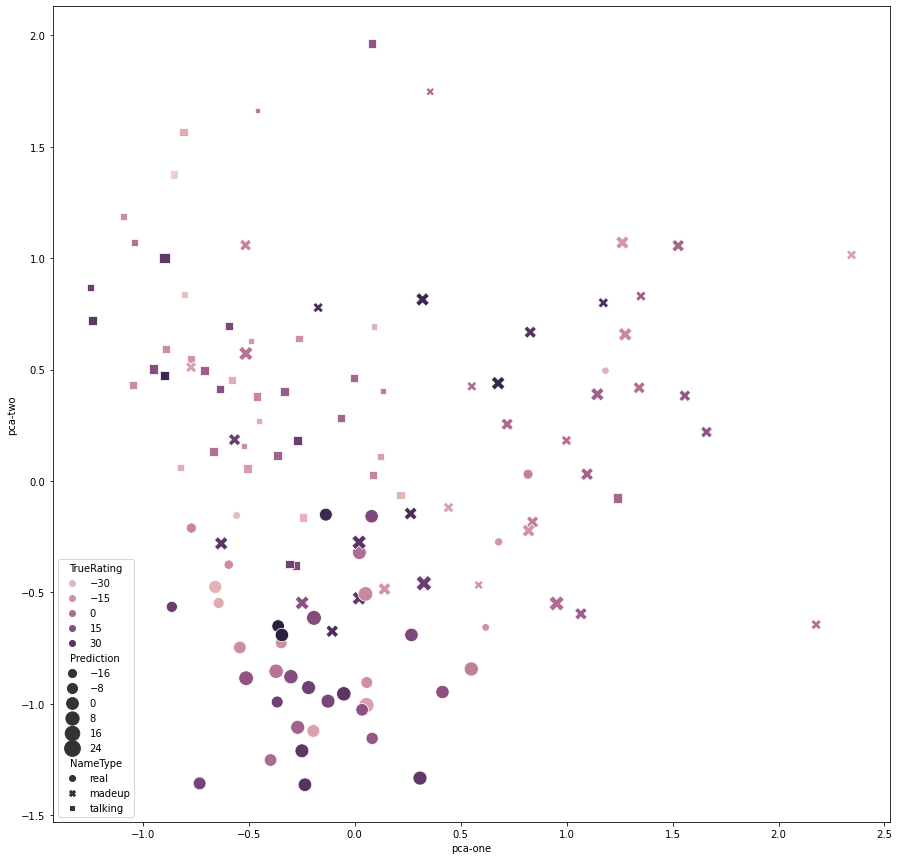

In [98]:
# AGE

feat_cols = [ 'd' + str(i) for i in range(age_PCA_ngram.shape[1]) ]
df = pd.DataFrame(age_PCA_ngram,columns=feat_cols)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(age_PCA_ngram)

age_PCA_ngram['pca-one'] = pca_result[:,0]
age_PCA_ngram['pca-two'] = pca_result[:,1]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

with open(csv_path + 'age_pred_nn.csv', 'r') as f:
  age_predictions = pd.read_csv(f)

  age_PCA_ngram['TrueRating'] = age_predictions['TrueRating']
  age_PCA_ngram['Prediction'] = age_predictions['NgramRating']
  age_PCA_ngram['NameType'] = age_predictions['NameType']

plt.figure(figsize=(15,15))
sns.scatterplot(
    x="pca-one", y="pca-two", hue = 'TrueRating', size = 'Prediction', style = 'NameType',
    #palette=sns.color_palette(),
    data=age_PCA_ngram,                                                         
    legend="brief",
    alpha=1,
    sizes = (50, 250)
)

Explained variation per principal component: [0.05517162 0.04732677]


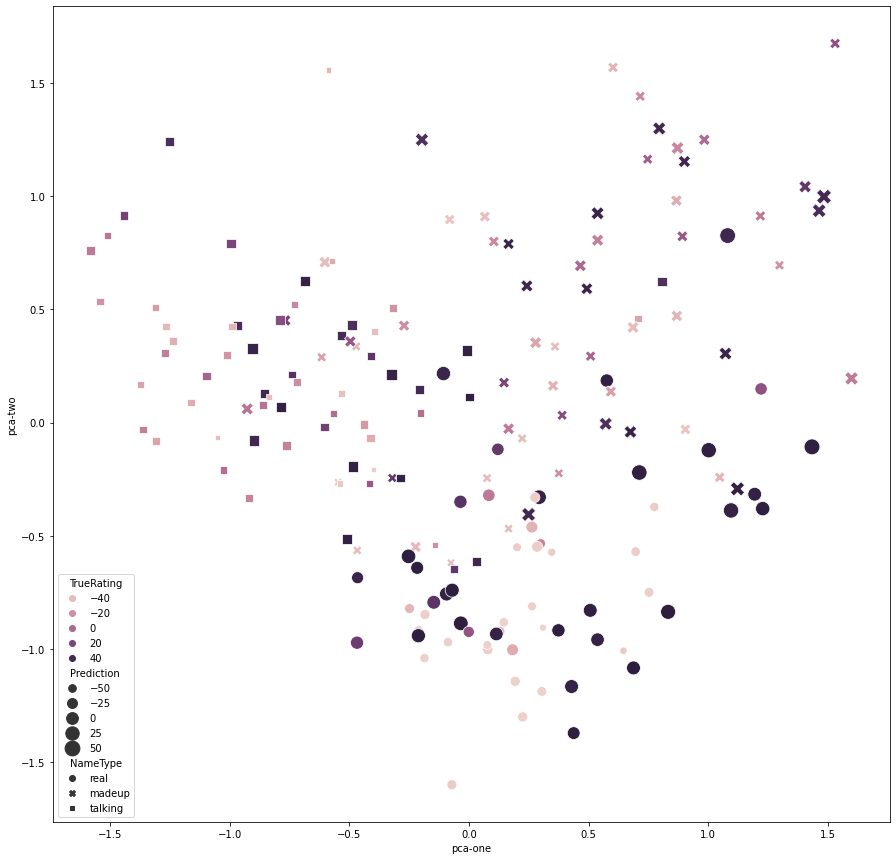

In [99]:
# GENDER

feat_cols = [ 'd' + str(i) for i in range(gender_PCA_ngram.shape[1]) ]
df = pd.DataFrame(gender_PCA_ngram,columns=feat_cols)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(gender_PCA_ngram)

gender_PCA_ngram['pca-one'] = pca_result[:,0]
gender_PCA_ngram['pca-two'] = pca_result[:,1]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

with open(csv_path + 'gender_pred_nn.csv', 'r') as f:
  gender_predictions = pd.read_csv(f)

  gender_PCA_ngram['TrueRating'] = gender_predictions['TrueRating']
  gender_PCA_ngram['Prediction'] = gender_predictions['NgramRating']
  gender_PCA_ngram['NameType'] = gender_predictions['NameType']

plt.figure(figsize=(15,15))
sns.scatterplot(
    x="pca-one", y="pca-two", hue = 'TrueRating', size = 'Prediction', style = 'NameType',
    #palette=sns.color_palette(),
    data=gender_PCA_ngram,                                                         
    legend="brief",
    alpha=1,
    sizes = (50, 250)
)

Explained variation per principal component: [0.07681256 0.05283083]


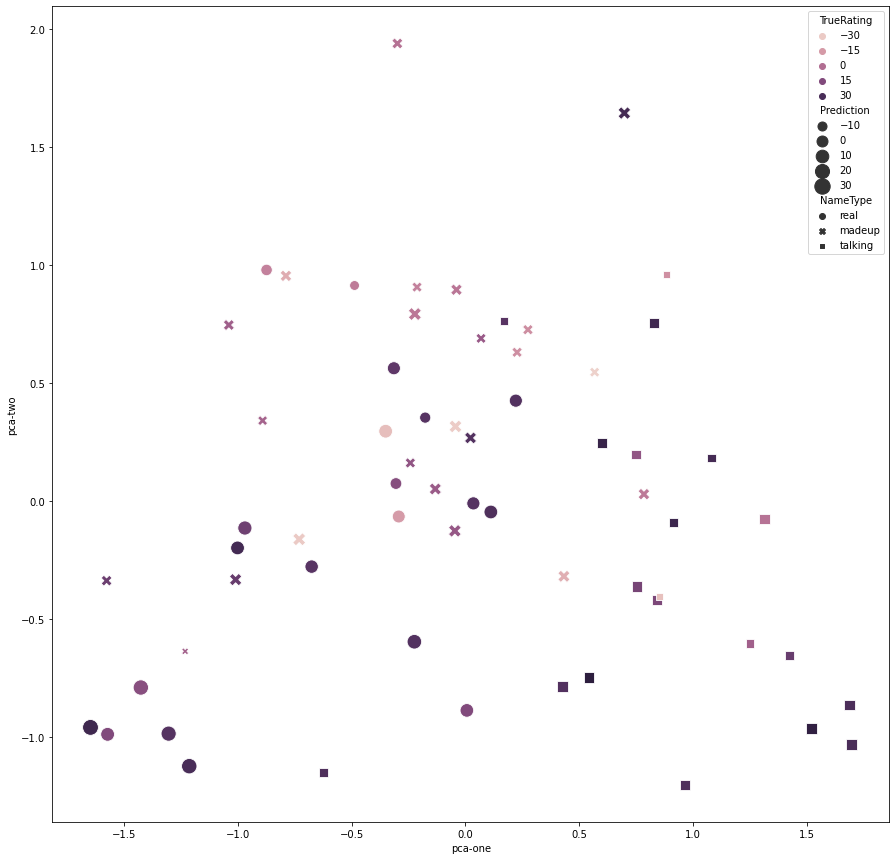

In [100]:
# POLARITY

feat_cols = [ 'd' + str(i) for i in range(polarity_PCA_ngram.shape[1]) ]
df = pd.DataFrame(polarity_PCA_ngram,columns=feat_cols)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(polarity_PCA_ngram)

polarity_PCA_ngram['pca-one'] = pca_result[:,0]
polarity_PCA_ngram['pca-two'] = pca_result[:,1]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

with open(csv_path + 'polarity_pred_nn.csv', 'r') as f:
  polarity_predictions = pd.read_csv(f)

  polarity_PCA_ngram['TrueRating'] = polarity_predictions['TrueRating']
  polarity_PCA_ngram['Prediction'] = polarity_predictions['NgramRating']
  polarity_PCA_ngram['NameType'] = polarity_predictions['NameType']

plt.figure(figsize=(15,15))
sns.scatterplot(
    x="pca-one", y="pca-two", hue = 'TrueRating', size = 'Prediction', style = 'NameType',
    #palette=sns.color_palette(),
    data=polarity_PCA_ngram,                                                         
    legend="brief",
    alpha=1,
    sizes = (50, 250)
)

##Prediction visualization
→ make sure to visualize the predictions (e.g., use ggpredict in R)


### Evaluation of Final Model (No Made-up Names)

##### Functions

In [ ]:
def fnn_maker_and_evaluator(x_train, y_train, x_test, y_test, pred_dict, 
                            test_names, test_name_types, nodes, dropout, lexical = None):
  # Input:
  # - x_train = array of embeddings used to train the model
  # - y_train = array of ratings used to train the model
  # - x_test = array of embeddings used to test the model
  # - y_test = array of ratings used to test the model
  # - pred_dict = a dictionary that will be filled with predictions per name
  # - test_names = dataframe containing the full names (i.e., not the embeddings) 
  # - test_name_types = dataframe containing the name type (real, madeup, talking)
  # - nodes = integer indicating the number of nodes to use in the hidden layer
  # - dropout = integer indicating the amount of dropout to use in the hidden layer

  # Process:
  # Train a sequential NN using the train set using fnn_maker(). Then, evaluate
  # the model using model_evaluator and return the values.

  # Output:
  # Too many to explain here. Basically, a bunch of metrics to test the model.

  #_, fnn_model = fnn_maker(x_train, y_train, x_test, y_test, nodes, dropout)
  
  fnn_model = fnn_maker(x_train, y_train, x_test, y_test, nodes, dropout)

  mae_test, mae_madeup, mae_real, mae_talking, mean_vec_mae_test \
  = model_evaluator(fnn_model, x_train, x_test, y_train, y_test, 
                    pred_dict, test_names, test_name_types, lexical)

  return mae_test, mae_madeup, mae_real, mae_talking, mean_vec_mae_test

In [ ]:
def neural_network_k_folder(df, rating, dimension, dictionary, nodes, dropout):
  # Input:
  # - df = a dataframe with the name, name_type, and rating for the dimension at  
  # hand (i.e., age, gender, or polarity)
  # - rating = a string indicating what rating to extract from the df
  # - dimension = a string indicating what dimension is considered (i.e., 'age',
  # 'gender', or 'polarity')
  # - dictionary = an empty dictionary to store the MSE output by fnn_maker() in 
  # per configuration
  # - nodes = integer indicating the number of nodes to use in the hidden layer
  # - dropout = integer indicating the amount of dropout to use in the hidden layer

  # Process:
  # Given the df, get 5 train/test splits, and per fold, train a NN model using
  # fnn_maker() for the combined, ngram, and lexical data. Then, store these
  # metrics in a .csv file.

  # Output: 
  # - pred_dict_combined: y_true and y_pred (for several conditions) per name (combined)
  # - pred_dict_ngram: y_true and y_pred (for several conditions) per name (ngram)
  # - pred_dict_lexical: y_true and y_pred (for several conditions) per name (lexical)

  loocv = LeaveOneOut()                                                         # Set up stratified LOOCV
  
  pred_dict_combined = {}                                                        # Set up three dictionaries to store the predicted y-values for the test names in
  pred_dict_ngram = {}
  pred_dict_lexical = {}

  for train_index, test_index in loocv.split(df):                               # For every fold (stratified on the name type, i.e., real, madeup, or talking)
    x_train_unfasttexted = df.iloc[train_index]                                 # Split the data into x_train and x_test
    x_test_unfasttexted = df.iloc[test_index]

    x_train_unf_lexical = x_train_unfasttexted[x_train_unfasttexted.name_type != 'madeup']
    x_test_unf_lexical = x_test_unfasttexted[x_test_unfasttexted.name_type != 'madeup']

    #x_train = fasttext_xifyer(x_train_unfasttexted)                             # Get the word embeddings
    #x_train_ngram = fasttext_xifyer_ngram(x_train_unfasttexted)

    x_train = fasttext_xifyer(x_train_unf_lexical)
    x_train_ngram = fasttext_xifyer_ngram(x_train_unf_lexical)
    
    x_train_lexical = fasttext_xifyer_lexical(x_train_unf_lexical)

    x_test = fasttext_xifyer(x_test_unf_lexical)
    x_test_ngram = fasttext_xifyer_ngram(x_test_unf_lexical)
    x_test_lexical = fasttext_xifyer_lexical(x_test_unf_lexical)


    y_train = df.iloc[train_index][rating]                                      # Split the data into y_train and y_test
    y_test = df.iloc[test_index][rating]

    y_train_lexical = df.iloc[train_index][df.name_type != 'madeup'][rating] 
    y_test_lexical = df.iloc[test_index][df.name_type != 'madeup'][rating]


    test_names = df.iloc[test_index]['name']                                    # Get a list of the names in the test set
    test_name_types = df.iloc[test_index]['name_type']                          # Get a list of name types corresponding to the names in the test set

    test_names_lexical = df.iloc[test_index][df.name_type != 'madeup']['name']                                    
    test_name_types_lexical = df.iloc[test_index][df.name_type != 'madeup']['name_type']                          

    try:
      if x_test[0] == "":
        print('hi')
    
    except IndexError:
      continue

    #try:
    mae_test, mae_madeup, mae_real, mae_talking, mean_vec_mae_test \
    = fnn_maker_and_evaluator(x_train, 
                              y_train_lexical, 
                              x_test, 
                              y_test_lexical, 
                              pred_dict_combined,
                              test_names_lexical,
                              test_name_types_lexical, 
                              nodes,
                              dropout)                                          # Train the NN given the fold, and return all of the variables of interest (combined)

    #except ValueError:
    #  continue

    mae_test_ngram, mae_madeup_ngram, mae_real_ngram, mae_talking_ngram, \
    mean_vec_mae_test_ngram \
    = fnn_maker_and_evaluator(x_train_ngram, 
                              y_train_lexical, 
                              x_test_ngram, 
                              y_test_lexical, 
                              pred_dict_ngram,
                              test_names_lexical,
                              test_name_types_lexical, 
                              nodes,
                              dropout)                                          # Train the NN given the fold, and return all of the variables of interest (ngram)
    
    #try:
    mae_test_lexical, mae_madeup_lexical, mae_real_lexical, mae_talking_lexical, \
    mean_vec_mae_test_lexical, \
    = fnn_maker_and_evaluator(x_train_lexical, 
                              y_train_lexical, 
                              x_test_lexical, 
                              y_test_lexical, 
                              pred_dict_lexical,
                              test_names_lexical,
                              test_name_types_lexical, 
                              nodes,
                              dropout, 
                              lexical = True)                                 # Train the NN given the fold, and return all of the variables of interest (lexical)

    dictionary['lexical'].append([mae_test_lexical, mae_madeup_lexical, 
                                mae_real_lexical, mae_talking_lexical,
                                mean_vec_mae_test_lexical])  # Append the variables of interest to the dictionary


    #except ValueError:
    #  pass

    dictionary['combined'].append([mae_test, mae_madeup, mae_real, mae_talking, 
                                  mean_vec_mae_test])                    # Append the variables of interest to the dictionary

    dictionary['ngram'].append([mae_test_ngram, mae_madeup_ngram, 
                                mae_real_ngram, mae_talking_ngram, 
                                mean_vec_mae_test_ngram])    # Append the variables of interest to the dictionary
    
  
  column_list = ('dimension', 'analysis_type', 'mae_test', 'mae_madeup', 
                 'mae_real', 'mae_talking', 'mean_vec_mae_test', 'sd_mae_total', 
                 'sd_mae_madeup', 'sd_mae_real', 'sd_mae_talking', 'sd_mean_vec_mae')         # List indicating all of the variables of interest 
  
  type_list = ['combined', 'ngram', 'lexical']                                  # List indicating the model type

  sd_dict_nn = {'combined' : {'total' : [], 'madeup': [], 'real': [], 'talking': [], 'mean_vec_mae': []}, 
                'ngram' : {'total' : [], 'madeup': [], 'real': [], 'talking': [], 'mean_vec_mae': []}, 
                'lexical': {'total' : [], 'madeup': [], 'real': [], 'talking': [], 'mean_vec_mae': []}}

  for analysis_type in type_list:    
    sd_mae_total = []
    sd_mae_madeup = []
    sd_mae_real = []
    sd_mae_talking = []

    sd_mean_vec_mae = []

    for iteration in dictionary[analysis_type]:
      sd_mae_total.append(iteration[0])
      sd_mae_madeup.append(iteration[1])
      sd_mae_real.append(iteration[2])
      sd_mae_talking.append(iteration[3])

      sd_mean_vec_mae.append(iteration[4])

    sd_dict_nn[analysis_type]['total'] = np.std(sd_mae_total)
    if analysis_type != None: #'lexical':
      sd_mae_madeup = list(filter(None, sd_mae_madeup))
      sd_dict_nn[analysis_type]['madeup'] = np.std(sd_mae_madeup)
    else:
      sd_dict_nn[analysis_type]['madeup'] = None
    
    sd_mae_real = list(filter(None, sd_mae_real))
    sd_dict_nn[analysis_type]['real'] = np.std(sd_mae_real)

    sd_mae_talking = list(filter(None, sd_mae_talking))
    sd_dict_nn[analysis_type]['talking'] = np.std(sd_mae_talking)

    sd_mae_sd_mean_vec_mae = list(filter(None, sd_mean_vec_mae))
    sd_dict_nn[analysis_type]['mean_vec_mae'] = np.std(sd_mean_vec_mae)

  combined_list = dictionary['combined']
  ngram_list = dictionary['ngram']
  lexical_list = dictionary['lexical']

  combined_list = [np.mean(x) for x in [list(filter(None, x)) for x in zip(*combined_list)]]                          

  ngram_list = [np.mean(x) for x in [list(filter(None, x)) for x in zip(*ngram_list)]]                                                

  lexical_list = [np.mean(x) for x in [list(filter(None, x)) for x in zip(*lexical_list)]]                  

  csv_df = []                                                                   # Create a list of lists that will be converted to a dataframe

  for value_list, analysis_type in zip([combined_list, ngram_list,            # Given the list of metrics for every model (combined, ngram, lexical)
                                        lexical_list], type_list):
    value_list.insert(0, analysis_type)                                         # Insert the name of the analysis type to the values (i.e., 'combined', etc.)
    value_list.insert(0, dimension)                                             # Insert the name of the dimension (i.e., 'age', 'gender', 'polarity') to the values
    value_list.append(sd_dict_nn[analysis_type]['total'])
    value_list.append(sd_dict_nn[analysis_type]['madeup'])
    value_list.append(sd_dict_nn[analysis_type]['real'])
    value_list.append(sd_dict_nn[analysis_type]['talking'])
    value_list.append(sd_dict_nn[analysis_type]['mean_vec_mae'])
    csv_df.append(value_list)                                                   # Add the list of values as a row to the DF list of lists
  
  csv_df = pd.DataFrame(csv_df, columns=column_list)                            # Convert the list of lists to a DF
  csv_df.to_csv(csv_path + dimension +'_nn_metrics.csv', index=False)           # Save the DF as a .csv file

  return pred_dict_combined, pred_dict_ngram, pred_dict_lexical

##### Running the functions

In [ ]:
age_dict_nn_final = {'combined' : [], 'ngram' : [], 'lexical': []}          # initialize the score dictionary for age

age_pred_dict_combined_nn, age_pred_dict_ngram_nn, \
age_pred_dict_lexical_nn = \
neural_network_k_folder(df_age, 'rating.mean_age', 'age', 
                        age_dict_nn_final, 300, 0.5)                            # Perform the 5-fold cross validation and save the metrics as a .csv file

pickle_age_nn_final = open(pickle_path + "age_nn_final.pickle", "wb")           # Save the dictionary to a pickle
pickle.dump(age_dict_nn_final, pickle_age_nn_final)
pickle_age_nn_final.close()

In [ ]:
age_pred_nn_df = []                                                             # Create a list of lists that will be converted to a dataframe

for i in sorted(df_age['name']):                                                # For every name in the dataframe
  i = i.lower()

  try:
    age_pred_nn_df.append([i, age_pred_dict_combined_nn[i][0],                     # Append the name, name type, and normal + mean_vector only predictions for the
                          age_pred_dict_combined_nn[i][1],                        # three model types as a row to the list of lists
                          age_pred_dict_combined_nn[i][2],
                          age_pred_dict_combined_nn[i + '_mean_vector'][2], 
                          age_pred_dict_ngram_nn[i][2], 
                          age_pred_dict_ngram_nn[i + '_mean_vector'][2], 
                          age_pred_dict_lexical_nn[i][2],
                          age_pred_dict_lexical_nn[i + '_mean_vector'][2]])
    
  except KeyError:
    continue
    age_pred_nn_df.append([i, age_pred_dict_combined_nn[i][0],                     # Append the name, name type, and normal + mean_vector only predictions for the
                          age_pred_dict_combined_nn[i][1],                        # three model types as a row to the list of lists
                          age_pred_dict_combined_nn[i][2],
                          age_pred_dict_combined_nn[i + '_mean_vector'][2], 
                          age_pred_dict_ngram_nn[i][2], 
                          age_pred_dict_ngram_nn[i + '_mean_vector'][2], 
                          None, None])
  
age_pred_nn_df = pd.DataFrame(age_pred_nn_df, columns=column_list_pred)         # Convert list of lists to DF

age_pred_nn_df.to_csv(csv_path + 'age_pred_nn.csv', index=False)                # Save DF as .csv

In [ ]:
gender_dict_nn_final = {'combined' : [], 'ngram' : [], 'lexical': []}       # initialize the score dictionary for gender

gender_pred_dict_combined_nn, gender_pred_dict_ngram_nn, \
gender_pred_dict_lexical_nn = \
neural_network_k_folder(df_gender, 'rating.mean_gender', 'gender', 
                        gender_dict_nn_final, 512, 0.3)                         # Perform the 5-fold cross validation and save the metrics as a .csv file

pickle_gender_nn_final = open(pickle_path + "gender_nn_final.pickle", "wb")     # Save the dictionary to a pickle
pickle.dump(gender_dict_nn_final, pickle_gender_nn_final)
pickle_gender_nn_final.close()

In [ ]:
gender_pred_nn_df = []                                                          # Create a list of lists that will be converted to a dataframe

for i in sorted(df_gender['name']):                                             # For every name in the dataframe
  i = i.lower()
  try:
    gender_pred_nn_df.append([i, gender_pred_dict_combined_nn[i][0],               # Append the name, name type, and normal + mean_vector only predictions for the
                          gender_pred_dict_combined_nn[i][1],                     # three model types as a row to the list of lists
                          gender_pred_dict_combined_nn[i][2],
                          gender_pred_dict_combined_nn[i + '_mean_vector'][2], 
                          gender_pred_dict_ngram_nn[i][2], 
                          gender_pred_dict_ngram_nn[i + '_mean_vector'][2], 
                          gender_pred_dict_lexical_nn[i][2],
                          gender_pred_dict_lexical_nn[i + '_mean_vector'][2]])

  except KeyError:
   continue
   gender_pred_nn_df.append([i, gender_pred_dict_combined_nn[i][0],               # Append the name, name type, and normal + mean_vector only predictions for the
                          gender_pred_dict_combined_nn[i][1],                     # three model types as a row to the list of lists
                          gender_pred_dict_combined_nn[i][2],
                          gender_pred_dict_combined_nn[i + '_mean_vector'][2], 
                          gender_pred_dict_ngram_nn[i][2], 
                          gender_pred_dict_ngram_nn[i + '_mean_vector'][2], 
                          None,
                          None])

gender_pred_nn_df = pd.DataFrame(gender_pred_nn_df, columns=column_list_pred)   # Convert list of lists to DF

gender_pred_nn_df.to_csv(csv_path + 'gender_pred_nn.csv', index=False)          # Save DF as .csv 

In [ ]:
polarity_dict_nn_final = {'combined' : [], 'ngram' : [], 'lexical': []}     # initialize the score dictionary for polarity

polarity_pred_dict_combined_nn, polarity_pred_dict_ngram_nn, \
polarity_pred_dict_lexical_nn = \
neural_network_k_folder(df_polarity, 'rating.mean_valence', 'polarity', 
                        polarity_dict_nn_final, 512, 0.5)                       # Perform the 5-fold cross validation and save the metrics as a .csv file

pickle_polarity_nn_final = open(pickle_path + "polarity_nn_final.pickle", "wb") # Save the dictionary to a pickle
pickle.dump(polarity_dict_nn_final, pickle_polarity_nn_final)
pickle_polarity_nn_final.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: Boolean Series key will be

[12.62522841454591, nan, 11.387783288955688, 13.86267385482788, 16.383217949512876]


In [ ]:
polarity_pred_nn_df = []                                                        # Create a list of lists that will be converted to a dataframe

for i in sorted(df_polarity['name']):                                            # For every name in the dataframe
  i = i.lower()
  
  try:
    polarity_pred_nn_df.append([i, polarity_pred_dict_combined_nn[i][0],           # Append the name, name type, and normal + mean_vector only predictions for the
                                polarity_pred_dict_combined_nn[i][1],              # three model types as a row to the list of lists
                                polarity_pred_dict_combined_nn[i][2],
                                polarity_pred_dict_combined_nn[i + '_mean_vector'][2], 
                                polarity_pred_dict_ngram_nn[i][2], 
                                polarity_pred_dict_ngram_nn[i + '_mean_vector'][2], 
                                polarity_pred_dict_lexical_nn[i][2],
                                polarity_pred_dict_lexical_nn[i + '_mean_vector'][2]])
    
  except KeyError:
    continue
    polarity_pred_nn_df.append([i, polarity_pred_dict_combined_nn[i][0],           # Append the name, name type, and normal + mean_vector only predictions for the
                                polarity_pred_dict_combined_nn[i][1],              # three model types as a row to the list of lists
                                polarity_pred_dict_combined_nn[i][2],
                                polarity_pred_dict_combined_nn[i + '_mean_vector'][2], 
                                polarity_pred_dict_ngram_nn[i][2], 
                                polarity_pred_dict_ngram_nn[i + '_mean_vector'][2], 
                                None, None])
  
polarity_pred_nn_df = pd.DataFrame(polarity_pred_nn_df, columns=column_list_pred) # Convert list of lists to DF

polarity_pred_nn_df.to_csv(csv_path + 'polarity_pred_nn.csv', index=False)   # Save DF as .csv

#### Adding all metrics CSVs together

In [ ]:
csv_complete = []                                                               # Create list of lists, that will be converted to a DF

for file_name in sorted(os.listdir(csv_path)):                                  # Locate all files in the folder
  if file_name == 'complete_metrics.csv':
    pass
  else:
    if file_name[-11:] == 'metrics.csv':                                          # If the files ends with 'metrics.csv'
      df_temp = pd.read_csv(csv_path + file_name)                                 # Convert the .csv file to a DF

      if file_name[-14:] == 'nn_metrics.csv':                                     # If the file has neural network metrics
        for row in df_temp.values.tolist():                                       # For every row
          row = row[:2] + ['Neural Network'] + row[2:] + [None, None, None, None] # Add none to the metrics that don't apply to neural networks (e.g., alpha, l1_ratio)
          csv_complete.append(row)                                                # Append the row to the list of lists
      else:                                                                       # Else
        columns = list(df_temp.columns)                                           # Save the column names as a list
        columns = columns[:2] + ['model_type'] + columns[6:] + columns[2:6]               
        for row in df_temp.values.tolist():                                       # For every row in the ElasticNet metrics
          row = row[:2] + ['ElasticNet'] + row[6:] + row[2:6]
          csv_complete.append(row)                                                # Append the row to the list of lists

csv_complete = pd.DataFrame(csv_complete, columns=columns)                  # Convert list of lists to a DF
csv_complete.to_csv(csv_path + 'complete_metrics.csv', index=False)             # Save DF as a .csv file